In [5]:
%matplotlib notebook
#import matplotlib.pyplot as plt
# Note! ITK interacts weirdly here.  from lazy_imports import itk does not work.
# Additionally, import itk must occur before lazy_imports for itkwidgets.view (ie itkview) to work.
import itk
import vtk
#from lazy_imports import itk
from lazy_imports import np
from lazy_imports import plt
import matplotlib as mpl
from lazy_imports import sitk
from lazy_imports import loadmat, savemat
from lazy_imports import sio
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv
from lazy_imports import torch
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)

In [2]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path
from disp.vis import view_3d_tensors, tensors_to_mesh, view_3d_paths, path_to_tube

In [6]:
from data.io import readRaw, ReadScalars, ReadTensors, WriteTensorNPArray, WriteScalarNPArray, readPath3D
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP
import algo.metricModSolver as mms
import algo.geodesic as geo
import algo.euler as euler
import util.tensors as tensors
import util.diffeo as diffeo
import _pickle as pickle
import math
import ipywebrtc
from IPython.display import display
import time

In [4]:
# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'tab:gray', 'tab:brown', 'm', 'y', 'tab:olive', 'maroon']
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']

blue=interp_colors[3]
ltblue=interp_colors[6]
yellow=interp_colors[7]
orange=interp_colors[9]
red=interp_colors[12]

# 3 classes are safest, but fewer options.
# Stitch together some options from sequential 3 values YlGnBu (reverse order), YlOrBr and 
#interp_colors = ['#2c7fb8', '#7fcdbb', '#edf8b1', '#fff7bc', '#fec44f', '#d95f0e']

# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']
# leave out #ffffcc and #ffffd4

blue=interp_colors[1]
ltblue=interp_colors[2]
yellow=interp_colors[4]
orange=interp_colors[5]
red=interp_colors[7]

# Same as above but with a dark gray added in the front
interp_colors = ['#777777','#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

blue=interp_colors[2]
ltblue=interp_colors[3]
yellow=interp_colors[5]
orange=interp_colors[6]
red=interp_colors[8]

# matches defaults
XSMALL_SIZE = 12
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
# bigger for papers
XSMALL_SIZE = 12
SMALL_SIZE = 17
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

animation_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlas_3D_animation/'
atlas_geo_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/b1000_UKF/'

In [5]:
run_case = 'annulus'
run_case = '103818'
#start_coords = [[62,126,56]]
#run_case = '105923'
#start_coords = [[61,125,56]]
#run_case = '111312'
#start_coords = [[62,128,56]]
#run_case = '103818up2'
#start_coords = [[124,252,112]]
cases = []
#all_start_coords = []
#cases.append('103818')
#all_start_coords.append([[62,126,56]])
cases.append('105923')
#all_start_coords.append([[61,125,56]])
#cases.append('111312')
#all_start_coords.append([[62,128,56]])
cases.append('102715')
cases.append('108222')
t1s = []
in_tensors = []
out_tensors = []
outdirs = []
out_masks = []
alphas = []
fas = []
for run_case in cases:
  subj = run_case[:6]
  #outroot='/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python/'
  outroot = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/'
  #indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_data/' + subj + '/'
  indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/' + subj + '/'
  outdir = f'{outroot}{run_case}_'
  outdirs.append(outdir)

  tens_file = 'dti_all_tensor.nhdr'
  in_tens = ReadTensors(indir + tens_file)
  in_tensors.append(in_tens)
  tens_file = 'scaled_tensors.nhdr'
  out_tens = ReadTensors(outdir + tens_file)
  out_tensors.append(out_tens)
  #t1_file = 't1_stripped_irescaled.nhdr'
  #t1 = ReadScalars(indir + t1_file)
  t1_file = 'T1.nhdr'
  t1 = ReadScalars(outdir + t1_file)
  t1s.append(t1)
  #t1_flip = ReadScalars(indir + 't1_rescaled_flipped.nhdr')[:,::-1,:]
  mask_file = 'filt_mask.nhdr'
  mask = ReadScalars(outdir + mask_file)
  out_masks.append(mask)
  alpha_file = 'alpha.nhdr'
  alpha = ReadScalars(outdir + alpha_file)
  alphas.append(alpha)
  fa_file = 'dti_all_FA.nhdr'
  fa = ReadScalars(indir + fa_file)
  fas.append(fa)
    
# atlas generated using only metric matching    
#atlasdir = '/home/sci/hdai/Projects/Atlas3D/output/BrainAtlasUkfBallAug27ScaledOrig/'
#outatlasdir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlases/BrainAtlasUkfBallAug27ScaledOrig/'
#orig_atlas_tens = ReadTensors(atlasdir + 'atlas_0_tens.nhdr')
#orig_atlas_mask = ReadScalars(atlasdir + 'atlas_0_mask.nhdr')
#orig_atlas_mask[orig_atlas_mask < 0.001] = 0
#orig_atlas_mask[orig_atlas_mask > 0] = 1
#orig_mask_tens = np.einsum('ijk...,ijk->ijk...',orig_atlas_tens,orig_atlas_mask)
#WriteTensorNPArray(orig_mask_tens,outatlasdir + 'masked_atlas_0_tens.nhdr')
#atlas_tens = ReadTensors(atlasdir + 'atlas_tens_phi_inv.nhdr')
#atlas_mask = ReadScalars(atlasdir + 'atlas_mask_phi_inv.nhdr')
#WriteTensorNPArray(mask_tens,outatlasdir + 'masked_atlas_tens_phi_inv.nhdr')

# atlas generated with only metric matching
#atlasdir = '/home/sci/hdai/Projects/Atlas3D/output/BrainAtlasUkfBallMetSept11/'
#outatlasdir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlases/BrainAtlasUkfBallMetSept11/'
#atlas_tens = ReadTensors(atlasdir + 'atlas_tens_phi_inv_met_rreg_800.nhdr')
#atlas_mask = ReadScalars(atlasdir + 'atlas_mask_phi_inv_met_rreg_800.nhdr')
# use T1 to get whole brain mask
#atlas_mask = ReadScalars(atlasdir + 'atlas_img_phi_inv_met_rreg_800.nhdr')
#atlas_mask[atlas_mask < 0.2] = 0 # 0.03
#atlas_mask[atlas_mask > 0.1] = 1 # 0.03
#mask_tens = np.einsum('ijk...,ijk->ijk...',atlas_tens,atlas_mask)
#WriteTensorNPArray(mask_tens,outatlasdir + 'masked_atlas_tens_phi_inv_met_rreg_800.nhdr')

# atlas generated with joint metric and image matching
#atlasdir = '/home/sci/hdai/Projects/Atlas3D/output/BrainAtlasUkfBallImgMetDirectRegSept10/'
#outatlasdir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlases/BrainAtlasUkfBallImgMetDirectRegSept10/'
#atlas_tens = ReadTensors(atlasdir + 'atlas_tens_phi_inv_img_met_rreg_800.nhdr')
#atlas_mask = ReadScalars(atlasdir + 'atlas_mask_phi_inv_img_met_rreg_800.nhdr')
# use T1 to get whole brain mask
#atlas_mask = ReadScalars(atlasdir + 'atlas_img_phi_inv_img_met_rreg_800.nhdr')
#atlas_mask = ReadScalars(atlasdir + 'atlas_img_phi_inv_met_rreg_800.nhdr')
#atlas_mask[atlas_mask < 0.2] = 0 # 0.03
#atlas_mask[atlas_mask > 0.1] = 1 # 0.03
#mask_tens = np.einsum('ijk...,ijk->ijk...',atlas_tens,atlas_mask)
#WriteTensorNPArray(mask_tens,outatlasdir + 'masked_atlas_tens_phi_inv_img_met_rreg_800.nhdr')


# Redo 2D synthetic geodesic plot

In [6]:
def mean_of_min_dist(curve1, curve2):
#     length = min(curve1.shape[0], curve2.shape[0])
# #     dist_array = np.sqrt((curve1[:length,0]-curve2[:length,0])**2+(curve1[:length,1]-curve2[:length,1])**2)
#     dist_array = np.sqrt((curve1[-length:,0]-curve2[-length:,0])**2+(curve1[-length:,1]-curve2[-length:,1])**2)
    min_list = []
    for i in range(curve1.shape[0]):
        min_list.append(np.min(np.sqrt((curve2[:,0]-curve1[i,0])**2+(curve2[:,1]-curve1[i,1])**2)))
#     return np.min(dist_array)
    return np.mean(np.array(min_list))

In [14]:
indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestData'
outdir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_2d_python/'
cubic_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/'
#cubic_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/CubicTemplateL2/'
#cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/Cubic1246TemplateEbin/'
#cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic1246TemplateL2/'
#cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic1246TemplateEbin1k/'
cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic1246TemplateEbin/'
cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic1246TemplateEbinReg1e-2/'
#cubic1246_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvNSCubic1246TemplateEbin/'
#cubic3467_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic3467TemplateL2/'
cubic3467_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic3467TemplateEbin/'
#cubic3467_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/Cubic3467TemplateEbin/'
cubic6734_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/InvCubic6734TemplateEbin/'
#HC_Dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/ScaledBrainTemplate/'
#HC_Dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/ThreshBrainTemplate2k/'
HC_Dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/ThreshBrainTemplate6k/'
#HC_Dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/ThreshBrainTemplateEbin/'
#HC_Dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/FromHaocheng/ThreshBrainTemplateL2Ebin/'

hdai_path = '/home/sci/hdai/Projects/Atlas2D/Output/Cubic1246Atlas/'

fig_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/figures/'
do_save = True


In [8]:
indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestData'
start_coords_cubic = [[13, 13]] 
start_coords_cubic = [[13, 16]] 
start_coords_cubic = [[14, 19]] 
init_velocities = [None] 

num_iters = 4500
geo_delta_t = 0.1
euler_delta_t = 0.1
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_iters = 3250
xlim=(40,95)
ylim=(40,80)

res = {}

for cc in range(1,8):
  run_case = f"cubic{cc}"
  res[run_case] = {}
  tens_file = f'metpy_cubic{cc}_tens.nhdr'
  mask_file = f'metpy_cubic{cc}_mask.nhdr'
  in_tens = ReadTensors(indir+'/'+tens_file)
  in_mask = ReadScalars(indir+'/'+mask_file)
  xsz=in_mask.shape[0]
  ysz=in_mask.shape[1]
  out_prefix = outdir + run_case
  scaled_tens = ReadTensors(out_prefix+'_scaled_tensors.nhdr')
  filt_mask = ReadScalars(out_prefix+'_filt_mask.nhdr')

  scaled_tens_4_path = np.transpose(scaled_tens,(2,0,1))
  tens_4_path = np.transpose(in_tens,(2,0,1))

  res[run_case]['scaled_tens'] = scaled_tens_4_path
  res[run_case]['orig_tens'] = tens_4_path
  res[run_case]['mask'] = filt_mask
    
  geox, geoy = geo.geodesicpath(tens_4_path, filt_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
  scalegeox, scalegeoy = geo.geodesicpath(scaled_tens_4_path, filt_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
  eulx, euly = euler.eulerpath(tens_4_path, filt_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters)
  scaleeulx, scaleeuly = euler.eulerpath(scaled_tens_4_path, filt_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters)
  res[run_case]['geox'] = geox
  res[run_case]['geoy'] = geoy 
  res[run_case]['scalegeox'] = scalegeox
  res[run_case]['scalegeoy'] = scalegeoy
  res[run_case]['eulx'] = eulx
  res[run_case]['euly'] = euly 
  res[run_case]['scaleeulx'] = scaleeulx
  res[run_case]['scaleeuly'] = scaleeuly


Finding geodesic path from [14, 19] with initial velocity [0.37912153 0.92534689]
Finding geodesic path from [14, 19] with initial velocity [0.37912153 0.92534689]
Euler starting eigenvector: [0.37912152803328, 0.9253468900805313]
Euler starting eigenvector: [0.37912152803328003, 0.9253468900805313]
Finding geodesic path from [14, 19] with initial velocity [0.27094882 0.96259375]
Finding geodesic path from [14, 19] with initial velocity [0.27094882 0.96259375]
Euler starting eigenvector: [0.2709488241321669, 0.9625937537203303]
Euler starting eigenvector: [0.2709488241321669, 0.9625937537203303]
Finding geodesic path from [14, 19] with initial velocity [0.29190347 0.95644779]
Finding geodesic path from [14, 19] with initial velocity [0.29190347 0.95644779]
Euler starting eigenvector: [0.2919034668138846, 0.9564477853296727]
Euler starting eigenvector: [0.29190346681388457, 0.9564477853296727]
Finding geodesic path from [14, 19] with initial velocity [0.31323537 0.94967552]
Finding geod

In [9]:
#c3_7_km_tens = ReadTensors(cubic_dir + 'cubic3_7_scaled_km_tensors.nhdr')
#c4_6_km_tens = ReadTensors(cubic_dir + 'cubic3_7_scaled_km_tensors.nhdr')
#c3_7_tens = ReadTensors(cubic_dir + 'cubic3_7_scaled_latesttemplate_tensors.nhdr')
#c4_6_tens = ReadTensors(cubic_dir + 'cubic4_6_scaled_latesttemplate_tensors.nhdr')
#c3_7_km_tens = ReadTensors(cubic_dir + 'cubic3_7_scaled_km_tensors.nhdr')
#c4_6_km_tens = ReadTensors(cubic_dir + 'cubic3_7_scaled_km_tensors.nhdr')
#c3_7_tens = ReadTensors(cubic3467_dir + 'cubic_200_scaled_tensors.nhdr')
thresh = 2
#c3_7_tens = ReadTensors(cubic3467_dir + 'cubic_400_scaled_tensors.nhdr')
c3_7_tens = ReadTensors(cubic3467_dir + 'cubic_noweight_scaled_tensors.nhdr')
c3_7_mask = sio.loadmat(cubic3467_dir+'mask.mat')['mask']
c3_7_mask[c3_7_mask <= thresh] = 0
c3_7_mask[c3_7_mask >  thresh] = 1

no_weight_tens = ReadTensors(cubic3467_dir + 'cubic_noweight_scaled_tensors.nhdr')

c6734_tens = ReadTensors(cubic6734_dir + 'cubic_400_scaled_tensors.nhdr')
c6734_mask = sio.loadmat(cubic6734_dir+'mask.mat')['mask']
c6734_mask[c6734_mask <= thresh] = 0
c6734_mask[c6734_mask >  thresh] = 1

#c4_6_tens = ReadTensors(cubic1246_dir + 'cubic_400_scaled_tensors.nhdr')
#c4_6_tens = ReadTensors(cubic1246_dir + 'cubic_1k_scaled_tensors.nhdr')
#c4_6_tens = ReadTensors(cubic1246_dir + 'cubic_noweight_scaled_tensors.nhdr')
c4_6_tens = ReadTensors(cubic1246_dir + 'cubic_400_scaled_tensors.nhdr')
c4_6_mask = sio.loadmat(cubic1246_dir+'mask.mat')['mask']
c4_6_mask[c4_6_mask <= thresh] = 0
c4_6_mask[c4_6_mask >  thresh] = 1

c4_6_mean = ReadTensors(cubic1246_dir + 'cubic_0_scaled_tensors.nhdr')
c4_6_mean_mask = np.zeros_like(c4_6_mask)

# phi_inv for converting template to cubics
# phi for converting from cubics to template
for cc in [1,2,4,6]:
  #phi_inv_file = cubic1246_dir + f'Cubic{cc}_400_phi_inv_ebin.mat'
  #phi_file = cubic1246_dir + f'Cubic{cc}_400_phi_ebin.mat'
  #phi_inv_file = cubic1246_dir + f'Cubic{cc}_noweight_phi_inv_ebin.mat'
  #phi_file = cubic1246_dir + f'Cubic{cc}_noweight_phi_ebin.mat'
  phi_inv_file = cubic1246_dir + f'Cubic{cc}_400_phi_inv_ebin.mat'
  phi_file = cubic1246_dir + f'Cubic{cc}_400_phi_ebin.mat'
  res[f'cubic{cc}']['cubic_1246_phi_inv_mat'] = sio.loadmat(phi_inv_file)
  res[f'cubic{cc}']['cubic_1246_phi_mat'] = sio.loadmat(phi_file)
  c4_6_mean_mask += res[f'cubic{cc}']['mask']

c4_6_mean_mask[c4_6_mean_mask <= thresh] = 0
c4_6_mean_mask[c4_6_mean_mask > thresh] = 1

#for cc in [3,4,6,7]:
#  phi_inv_file = cubic3467_dir + f'Cubic{cc}_400_phi_inv_ebin.mat'
#  phi_file = cubic3467_dir + f'Cubic{cc}_400_phi_ebin.mat'
#  res[f'cubic{cc}']['cubic_3467_phi_inv_mat'] = sio.loadmat(phi_inv_file)
#  res[f'cubic{cc}']['cubic_3467_phi_mat'] = sio.loadmat(phi_file)



In [10]:
#scaled_c3_7_km_tens_4_path = np.transpose(c3_7_km_tens,(2,0,1))
#scaled_c4_6_km_tens_4_path = np.transpose(c4_6_km_tens,(2,0,1))
scaled_c3_7_tens_4_path = np.transpose(c3_7_tens,(2,0,1))

#c3_7_mask = np.zeros((c3_7_tens.shape[0],c3_7_tens.shape[1]))
##c3_7_mask[c3_7_tens[:,:,0]>0.5] = 1 # for tensor 
#c3_7_mask[c3_7_tens[:,:,0]>0.0002] = 1 # for inverse tensor

iso_tens = np.zeros((2,2))
iso_tens[0,0] = 1.0e-4 
iso_tens[1,1] = 1.0e-4 
nw_tens_full = np.zeros((100,100,2,2))
nw_tens_full[:,:,0,0] = no_weight_tens[:,:,0]
nw_tens_full[:,:,0,1] = no_weight_tens[:,:,1]
nw_tens_full[:,:,1,0] = no_weight_tens[:,:,1]
nw_tens_full[:,:,1,1] = no_weight_tens[:,:,2]
nw_inv_tens = np.linalg.inv(nw_tens_full)
nw_inv_tens[c3_7_mask==0] = iso_tens


iso_tens = np.zeros((2,2))
iso_tens[0,0] = 1.0e-4 
iso_tens[1,1] = 1.0e-4 
c37_tens_full = np.zeros((100,100,2,2))
c37_tens_full[:,:,0,0] = c3_7_tens[:,:,0]
c37_tens_full[:,:,0,1] = c3_7_tens[:,:,1]
c37_tens_full[:,:,1,0] = c3_7_tens[:,:,1]
c37_tens_full[:,:,1,1] = c3_7_tens[:,:,2]
inv_tens = np.linalg.inv(c37_tens_full)
inv_tens[c3_7_mask==0] = iso_tens
scaled_c3_7_tens_4_path = np.zeros((3,100,100))
scaled_c3_7_tens_4_path[0,:,:] = inv_tens[:,:,0,0]
scaled_c3_7_tens_4_path[1,:,:] = inv_tens[:,:,0,1]
scaled_c3_7_tens_4_path[2,:,:] = inv_tens[:,:,1,1]
c3_7_inv_tens = inv_tens

c6734_tens_full = np.zeros((100,100,2,2))
c6734_tens_full[:,:,0,0] = c6734_tens[:,:,0]
c6734_tens_full[:,:,0,1] = c6734_tens[:,:,1]
c6734_tens_full[:,:,1,0] = c6734_tens[:,:,1]
c6734_tens_full[:,:,1,1] = c6734_tens[:,:,2]
inv_tens = np.linalg.inv(c6734_tens_full)
inv_tens[c6734_mask==0] = iso_tens
scaled_c6734_tens_4_path = np.zeros((3,100,100))
scaled_c6734_tens_4_path[0,:,:] = inv_tens[:,:,0,0]
scaled_c6734_tens_4_path[1,:,:] = inv_tens[:,:,0,1]
scaled_c6734_tens_4_path[2,:,:] = inv_tens[:,:,1,1]

#scaled_c4_6_tens_4_path = np.transpose(c4_6_tens,(2,0,1))
#c4_6_mask = np.zeros((c4_6_tens.shape[0],c4_6_tens.shape[1]))
#c4_6_mask[c4_6_tens[:,:,0]>0.5] = 1
#c4_6_mask[c4_6_tens[:,:,0]>0.0002] = 1

iso_tens = np.zeros((2,2))
iso_tens[0,0] = 1.0e-4 
iso_tens[1,1] = 1.0e-4 
c46_tens_full = np.zeros((100,100,2,2))
c46_tens_full[:,:,0,0] = c4_6_tens[:,:,0]
c46_tens_full[:,:,0,1] = c4_6_tens[:,:,1]
c46_tens_full[:,:,1,0] = c4_6_tens[:,:,1]
c46_tens_full[:,:,1,1] = c4_6_tens[:,:,2]
inv_tens = np.linalg.inv(c46_tens_full)
inv_tens[c4_6_mask==0] = iso_tens
norm2 = np.linalg.norm(inv_tens,axis=(2,3))
#c4_6_mask[norm2<0.24] = 0
scaled_c4_6_tens_4_path = np.zeros((3,100,100))
scaled_c4_6_tens_4_path[0,:,:] = inv_tens[:,:,0,0]
scaled_c4_6_tens_4_path[1,:,:] = inv_tens[:,:,0,1]
scaled_c4_6_tens_4_path[2,:,:] = inv_tens[:,:,1,1]

c46_mean_full = np.zeros((100,100,2,2))
c46_mean_full[:,:,0,0] = c4_6_mean[:,:,0]
c46_mean_full[:,:,0,1] = c4_6_mean[:,:,1]
c46_mean_full[:,:,1,0] = c4_6_mean[:,:,1]
c46_mean_full[:,:,1,1] = c4_6_mean[:,:,2]
inv_tens = np.linalg.inv(c46_mean_full)
inv_tens[c4_6_mean_mask==0] = iso_tens
norm2 = np.linalg.norm(inv_tens,axis=(2,3))
#c4_6_mask[norm2<0.24] = 0
scaled_c4_6_mean_4_path = np.zeros((3,100,100))
scaled_c4_6_mean_4_path[0,:,:] = inv_tens[:,:,0,0]
scaled_c4_6_mean_4_path[1,:,:] = inv_tens[:,:,0,1]
scaled_c4_6_mean_4_path[2,:,:] = inv_tens[:,:,1,1]



In [11]:
scalec3_7geox, scalec3_7geoy = geo.geodesicpath(scaled_c3_7_tens_4_path, c3_7_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
scaleeulc3_7x, scaleeulc3_7y = euler.eulerpath(scaled_c3_7_tens_4_path, c3_7_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters) 
 
scalec6734geox, scalec6734geoy = geo.geodesicpath(scaled_c6734_tens_4_path, c6734_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
scaleeulc6734x, scaleeulc6734y = euler.eulerpath(scaled_c6734_tens_4_path, c6734_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters) 

scalec4_6geox, scalec4_6geoy = geo.geodesicpath(scaled_c4_6_tens_4_path, c4_6_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
scaleeulc4_6x, scaleeulc4_6y = euler.eulerpath(scaled_c4_6_tens_4_path, c4_6_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters) 

scalec4_6meangeox, scalec4_6meangeoy = geo.geodesicpath(scaled_c4_6_mean_4_path, c4_6_mean_mask,\
                              start_coords_cubic[0], init_velocities[0], \
                              geo_delta_t, iter_num=geo_iters)
scaleeulc4_6meanx, scaleeulc4_6meany = euler.eulerpath(scaled_c4_6_mean_4_path, c4_6_mean_mask,\
                              start_coords_cubic[0], init_velocities[0], euler_delta_t, iter_num=euler_iters) 


Finding geodesic path from [14, 19] with initial velocity [0.32240471 0.94660193]
Euler starting eigenvector: [0.32240470658902026, 0.9466019253990812]
Finding geodesic path from [14, 19] with initial velocity [0.27703165 0.9608608 ]
Euler starting eigenvector: [0.2770316453778585, 0.9608607950474598]
Finding geodesic path from [14, 19] with initial velocity [0.3253691  0.94558709]
masking pixel 21 10
Euler starting eigenvector: [0.32536910481223164, 0.9455870904542252]
Finding geodesic path from [14, 19] with initial velocity [0.32241862 0.94659719]
Euler starting eigenvector: [0.3224186207775198, 0.94659718622861]


In [12]:

flip_xy = True
if flip_xy:
  print("FLIPPING X-Y DIRECTION TO Y-X FOR COORD REGISTER")
else:
  print("Using standard x-y direction for coord register ")

if flip_xy:
  for cc in [1,2,4,6]:
    subj=f"cubic{cc}"
    geoy, geox = diffeo.coord_register(scalec4_6geoy, scalec4_6geox, res[subj]['cubic_1246_phi_inv_mat']['diffeo'])
    euly, eulx = diffeo.coord_register(scaleeulc4_6y, scaleeulc4_6x, res[subj]['cubic_1246_phi_inv_mat']['diffeo'])
    #seedy, seedx = diffeo.coord_register([start_coords_cubic[0][1]], [start_coords_cubic[0][0]],
    #                                                      res[subj]['cubic_1246_phi_inv_mat']['diffeo']) 
    seedy, seedx, seed_v = diffeo.coord_velocity_register([start_coords_cubic[0][1]], [start_coords_cubic[0][0]], 
                                                          scaled_c4_6_tens_4_path, geo_delta_t/100,
                                                          res[subj]['cubic_1246_phi_inv_mat']['diffeo']) 
    seedpt = [seedx[0],seedy[0]]
    
    # use phi for the pullback to subj space, but phi_inv for the coord transform to subj space
    gatlas = np.zeros((2,2,xsz,ysz))
    gatlas[0,0,:,:] = scaled_c4_6_tens_4_path[0,:,:]
    gatlas[0,1,:,:] = scaled_c4_6_tens_4_path[1,:,:]
    gatlas[1,0,:,:] = scaled_c4_6_tens_4_path[1,:,:]
    gatlas[1,1,:,:] = scaled_c4_6_tens_4_path[2,:,:]
    atlas_in_subj_space = diffeo.phi_pullback(torch.from_numpy(res[subj]['cubic_1246_phi_inv_mat']['diffeo']), 
                                              torch.from_numpy(gatlas)).detach().numpy()
    
    atlas_subj_space_upper = np.zeros((3,xsz,ysz))
    atlas_subj_space_upper[0,:,:] = atlas_in_subj_space[0,0,:,:]
    atlas_subj_space_upper[1,:,:] = atlas_in_subj_space[0,1,:,:]
    atlas_subj_space_upper[2,:,:] = atlas_in_subj_space[1,1,:,:]
    init_v = tensors.direction(seedpt, atlas_subj_space_upper)
    
    res[subj]['cubic_1246_subjspace'] = atlas_subj_space_upper
    res[subj]['cubic_1246_subjspace_geox'] = geox
    res[subj]['cubic_1246_subjspace_geoy'] = geoy
    res[subj]['cubic_1246_subjspace_eulx'] = eulx
    res[subj]['cubic_1246_subjspace_euly'] = euly
    res[subj]['cubic_1246_subjspace_seed'] = seedpt
    #res[subj]['cubic_1246_subjspace_init_v'] = seed_v[0]
    res[subj]['cubic_1246_subjspace_init_v'] = None
    #res[subj]['cubic_1246_subjspace_init_v'] = init_v

    geox, geoy = geo.geodesicpath(res[subj]['scaled_tens'], res[subj]['mask'],\
                              res[subj]['cubic_1246_subjspace_seed'], res[subj]['cubic_1246_subjspace_init_v'], \
                              geo_delta_t, iter_num=geo_iters, both_directions=False)
    eulx, euly = euler.eulerpath(res[subj]['scaled_tens'], res[subj]['mask'],\
                              res[subj]['cubic_1246_subjspace_seed'], res[subj]['cubic_1246_subjspace_init_v'], \
                              euler_delta_t, iter_num=euler_iters, both_directions=False)
    res[subj][subj+'_subjspace_geox'] = geox
    res[subj][subj+'_subjspace_geoy'] = geoy
    res[subj][subj+'_subjspace_eulx'] = eulx
    res[subj][subj+'_subjspace_euly'] = euly
    atlasgeoy, atlasgeox = diffeo.coord_register(geoy,geox,res[subj]['cubic_1246_phi_mat']['diffeo'])
    atlaseuly, atlaseulx = diffeo.coord_register(euly,eulx,res[subj]['cubic_1246_phi_mat']['diffeo'])
    res[subj][subj+'_atlasspace_geox'] = atlasgeox
    res[subj][subj+'_atlasspace_geoy'] = atlasgeoy
    res[subj][subj+'_atlasspace_eulx'] = atlaseulx
    res[subj][subj+'_atlasspace_euly'] = atlaseuly
   
else:
  print("Not Implemented for cubic")



FLIPPING X-Y DIRECTION TO Y-X FOR COORD REGISTER
WARNING WARNING WARNING!!! Treat the following velocity code as highly suspect!!!
Finding geodesic path from [13.6236542061141, 15.569894008191689] with initial velocity [0.34029207 0.94031979]
Euler starting eigenvector: [0.3402920725213805, 0.9403197888905155]
WARNING WARNING WARNING!!! Treat the following velocity code as highly suspect!!!
Finding geodesic path from [14.836668182448795, 23.213850256458215] with initial velocity [0.31076341 0.9504873 ]
Euler starting eigenvector: [0.310763408770993, 0.950487298057703]
WARNING WARNING WARNING!!! Treat the following velocity code as highly suspect!!!
Finding geodesic path from [13.737054584914295, 19.22422564019134] with initial velocity [0.31456938 0.94923448]
Euler starting eigenvector: [0.3145693847243078, 0.949234482198245]
WARNING WARNING WARNING!!! Treat the following velocity code as highly suspect!!!
Finding geodesic path from [13.861554317500806, 18.397713122969705] with initial

In [ ]:
geo_line_width=20
eul_line_width=4

tens_scale = 0.2
#cubic_inv_tens_scale = 0.001
inv_tens_scale = 0.0003
show_axis_labels = False

tens_opacity = 0.75

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [40,85] # center, top

tens_fig=plt.figure(figsize=(6,4))
rows = 2
cols = 3 # Each individual takes 1 column and 1 row, atlas is in far right column

grid = plt.GridSpec(rows, cols, top=1, bottom=0, right=1, left=0, wspace=0, hspace=0)

ax00 = plt.subplot(grid[0,0])
vis_tensors(res['cubic2']['scaled_tens'], '', False,mask=res['cubic2']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax00,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic2']['cubic2_subjspace_geox'], res['cubic2']['cubic2_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[0], geo_line_width/4, 1, False, ax=ax00,zorder=-20, stride=2)
#vis_path(res['cubic2']['cubic_1246_subjspace_geox'], res['cubic2']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax00)
plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax00.text(label_pt[0], label_pt[1], "Metric 1", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax00.set_xticks([])
  ax00.set_yticks([])
ax00.get_legend().remove() 
ax00.set_axis_off()
ax00.xaxis.set_major_locator(plt.NullLocator())
ax00.yaxis.set_major_locator(plt.NullLocator())
#ax00.set_rasterized(True)
ax00.set_rasterization_zorder(-5)

ax01 = plt.subplot(grid[0,1])
vis_tensors(res['cubic4']['scaled_tens'], '', False,mask=res['cubic4']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax01,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic4']['cubic4_subjspace_geox'], res['cubic4']['cubic4_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[1], geo_line_width/4, 1, False, ax=ax01,zorder=-20, stride=2)
#vis_path(res['cubic4']['cubic_1246_subjspace_geox'], res['cubic4']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax01)
plt.plot(res['cubic4']['cubic_1246_subjspace_seed'][0],res['cubic4']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax01.text(label_pt[0], label_pt[1], "Metric 2", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax01.set_xticks([])
  ax01.set_yticks([])
ax01.get_legend().remove()  
ax01.set_axis_off()
ax01.xaxis.set_major_locator(plt.NullLocator())
ax01.yaxis.set_major_locator(plt.NullLocator())
#ax01.set_rasterized(True)
ax01.set_rasterization_zorder(-5)

ax10 = plt.subplot(grid[1,0])
vis_tensors(res['cubic6']['scaled_tens'], '', False,mask=res['cubic6']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax10,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic6']['cubic6_subjspace_geox'], res['cubic6']['cubic6_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[2], geo_line_width/4, 1, False, ax=ax10,zorder=-20, stride=2)
#vis_path(res['cubic6']['cubic_1246_subjspace_geox'], res['cubic6']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax10)
plt.plot(res['cubic6']['cubic_1246_subjspace_seed'][0],res['cubic6']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax10.text(label_pt[0], label_pt[1], "Metric 3", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax10.set_xticks([])
  ax10.set_yticks([])
ax10.get_legend().remove()  
ax10.set_axis_off()
ax10.xaxis.set_major_locator(plt.NullLocator())
ax10.yaxis.set_major_locator(plt.NullLocator())
#ax10.set_rasterized(True)
ax10.set_rasterization_zorder(-5)

ax11 = plt.subplot(grid[1,1])
vis_tensors(res['cubic1']['scaled_tens'], '', False,mask=res['cubic1']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax11,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic1']['cubic1_subjspace_geox'], res['cubic1']['cubic1_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[3], geo_line_width/4, 1, False, ax=ax11,zorder=-20, stride=2)
#vis_path(res['cubic1']['cubic_1246_subjspace_geox'], res['cubic1']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax11)
plt.plot(res['cubic1']['cubic_1246_subjspace_seed'][0],res['cubic1']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax11.text(label_pt[0], label_pt[1], "Metric 4", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax11.set_xticks([])
  ax11.set_yticks([])
ax11.get_legend().remove()  
ax11.set_axis_off()
ax11.xaxis.set_major_locator(plt.NullLocator())
ax11.yaxis.set_major_locator(plt.NullLocator())
#ax11.set_rasterized(True)
ax11.set_rasterization_zorder(-5)

#ax2 = plt.subplot(grid[0:2, 2:4])
ax02 = plt.subplot(grid[0, 2])
vis_tensors(scaled_c4_6_tens_4_path, '', False,mask=c4_6_mask,scale=inv_tens_scale*2, ax=ax02,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic2']['scalegeox'], res['cubic2']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[0], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
vis_path(res['cubic4']['scalegeox'], res['cubic4']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[1], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
vis_path(res['cubic6']['scalegeox'], res['cubic6']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[2], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
vis_path(res['cubic1']['scalegeox'], res['cubic1']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[3], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
vis_path(scalec4_6geox, scalec4_6geoy, tens_fig, f"Atlas Geodesic", 
         orange, geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
plt.plot(start_coords_cubic[0][0], start_coords_cubic[0][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax02.text(label_pt[0], label_pt[1], "Geodesics", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax02.set_xticks([])
  ax02.set_yticks([])
ax02.get_legend().remove()  
ax02.set_axis_off()
ax02.xaxis.set_major_locator(plt.NullLocator())
ax02.yaxis.set_major_locator(plt.NullLocator())
#ax02.set_rasterized(True)
ax02.set_rasterization_zorder(-5)

#ax2 = plt.subplot(grid[0:2, 2:4])
ax12 = plt.subplot(grid[1, 2])
vis_tensors(scaled_c4_6_tens_4_path, '', False,mask=c4_6_mask,scale=inv_tens_scale*2, ax=ax12,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic2']['cubic2_atlasspace_geox'], res['cubic2']['cubic2_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[0], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic4']['cubic4_atlasspace_geox'], res['cubic4']['cubic4_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[1], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic6']['cubic6_atlasspace_geox'], res['cubic6']['cubic6_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[2], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic1']['cubic1_atlasspace_geox'], res['cubic1']['cubic1_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[3], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(scalec4_6geox, scalec4_6geoy, tens_fig, f"Atlas Geodesic", 
         orange, geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
plt.plot(start_coords_cubic[0][0], start_coords_cubic[0][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax12.text(label_pt[0], label_pt[1], "Atlas", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax12.set_xticks([])
  ax12.set_yticks([])
ax12.get_legend().remove()  
ax12.set_axis_off()
ax12.xaxis.set_major_locator(plt.NullLocator())
ax12.yaxis.set_major_locator(plt.NullLocator())
#ax12.set_rasterized(True)
#ax12.set_rasterization_zorder(-5)

#plt.margins(0,0)
if do_save:
  plt.gcf().savefig(fig_dir + 'cubic_atlas_all_reg1e-2_layout2_geodesics.pdf', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)



## Hausdorff between registered geodesic on cubic1 and geodesic on atlas/cubic5

In [30]:
%%time
# ground truth geodesic is cubic 5
gt_geox = res['cubic5']['geox']
gt_geoy = res['cubic5']['geoy']

cubic_to_atlas_dist = {}
cubic_to_gt_dist = {}

for cc in [1,2,4,6]:
  subj=f"cubic{cc}"
  cubic_to_atlas_dist[subj] = []
  cubic_to_gt_dist[subj] = []
    
  for i in range(0,101,5):
  #for i in range(0,401,10):
# if True:
#     i=80
    phi = sio.loadmat(f'{hdai_path}Output/Cubic1246Atlas/{subj}_{i}_phi.mat')['diffeo']
    #phi = sio.loadmat(cubic1246_dir + f'Cubic{cc}_{i}_phi_ebin.mat')['diffeo']
 
    new_geoy, new_geox = diffeo.coord_register(res[subj][f'{subj}_subjspace_geoy'], 
                                        res[subj][f'{subj}_subjspace_geox'], 
                                        phi)
#     tens_fig = vis_tensors(ten_4_path, f'cubic_12_geodesic_{i}', False, scale=tens_scale)
# #     vis_path(geox, geoy, tens_fig, "cubic", 'tab:blue', 40, 1, False)
#     vis_path(new_geox[800:802], new_geoy[800:802], tens_fig, "registered", 'tab:red', 40, 1, False)
# #     vis_path(gt_geox, gt_geoy, tens_fig, "groundtruth", 'tab:green', 40, 1, False)
#     vis_path(atlas_geox[900:902], atlas_geoy[900:902], tens_fig, "atlas", 'tab:orange', 40, 1, False)
    
    geo_subject_registered = np.concatenate((np.expand_dims(np.array(new_geox),axis=1),
                                             np.expand_dims(np.array(new_geoy),axis=1)),axis=1)
    geo_gt = np.concatenate((np.expand_dims(np.array(gt_geox),axis=1),
                             np.expand_dims(np.array(gt_geoy),axis=1)),axis=1)
    geo_atlas = np.concatenate((np.expand_dims(np.array(scalec4_6geox),axis=1),
                                np.expand_dims(np.array(scalec4_6geoy),axis=1)),axis=1)
#     dist_hausdorff = directed_hausdorff(geo_subject_registered, geo_atlas)[0]
#     cubic1_dist.append(dist_hausdorff)
#     print(dist_hausdorff)
    dist_mean = mean_of_min_dist(geo_subject_registered, geo_atlas)
    cubic_to_atlas_dist[subj].append(dist_mean)
    dist_mean = mean_of_min_dist(geo_subject_registered, geo_gt)
    cubic_to_gt_dist[subj].append(dist_mean)


CPU times: user 9.95 s, sys: 10.2 ms, total: 9.96 s
Wall time: 10.8 s


<IPython.core.display.Javascript object>


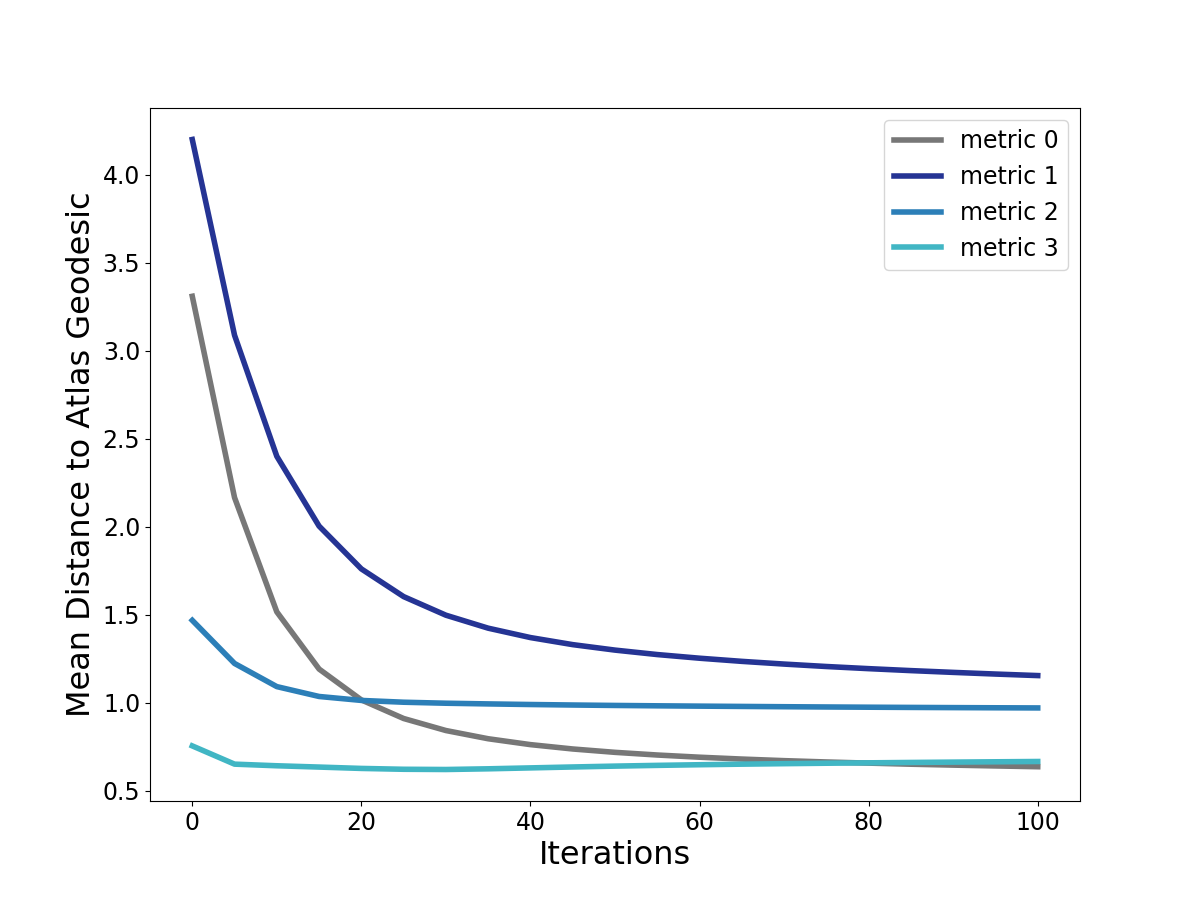

In [38]:
plt.figure(figsize=(12,9))
line_width=4
cidx=0
for cc in [1,2,4,6]:
  subj=f"cubic{cc}"
  plt.plot(list(range(0,101,5)),cubic_to_atlas_dist[subj], lw=line_width,
           label=f'metric {cidx}', color=interp_colors[cidx])
  #plt.plot(list(range(0,401,10)),cubic_to_atlas_dist[subj], label=f'metric {cidx}', color=interp_colors[cidx])
  cidx += 1
plt.legend(loc='upper right', ncol=1)
# plt.title(f'Mean distance between the geodesics on subjects and atlas')
plt.xlabel('Iterations')
plt.ylabel('Mean Distance to Atlas Geodesic')
if do_save:
  plt.savefig(f'{fig_dir}dist_plot.pdf')

<IPython.core.display.Javascript object>


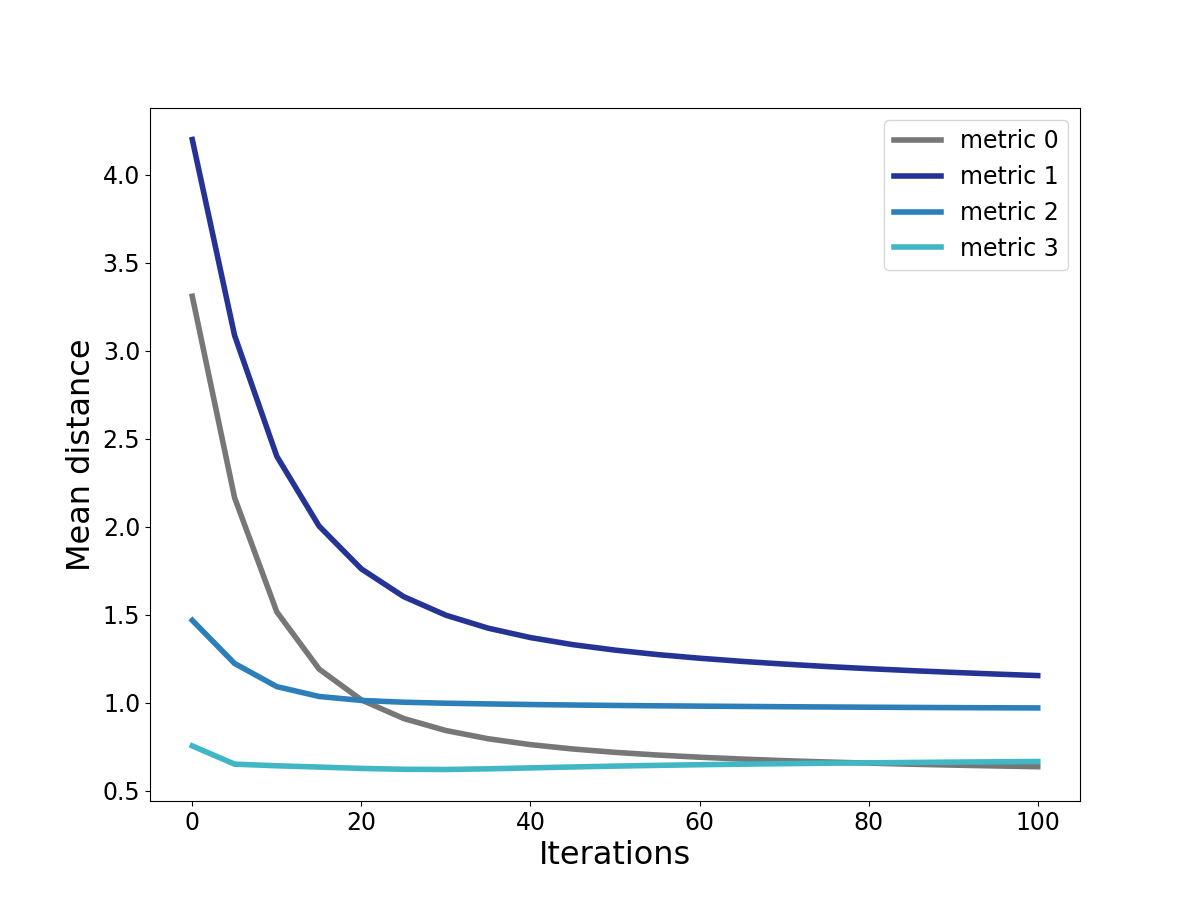

In [37]:
plt.figure(figsize=(12,9))
line_width=4
cidx=0
for cc in [1,2,4,6]:
  subj=f"cubic{cc}"
  plt.plot(list(range(0,101,5)),cubic_to_atlas_dist[subj], lw=line_width,
           label=f'metric {cidx}', color=interp_colors[cidx])
  #plt.plot(list(range(0,401,10)),cubic_to_atlas_dist[subj], label=f'metric {cidx}', color=interp_colors[cidx])
  cidx += 1
plt.legend(loc='upper right', ncol=1)
# plt.title(f'Mean distance between the geodesics on subjects and atlas')
plt.xlabel('Iterations')
plt.ylabel('Mean Distance to Ground Truth Geodesic')
if do_save:
  plt.savefig(f'{fig_dir}dist_gt_plot.pdf')

<IPython.core.display.Javascript object>


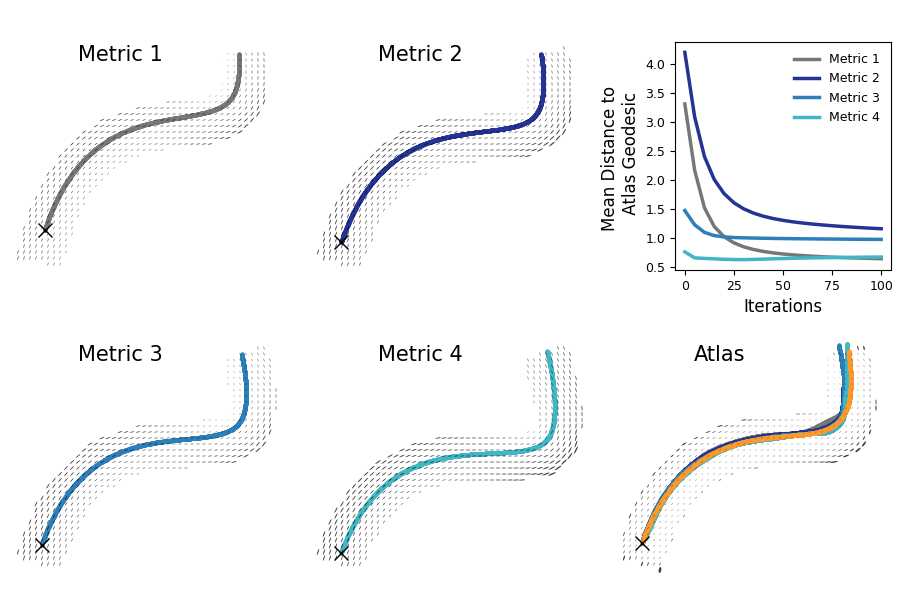

Bbox(x0=0.6666666666666666, y0=0.5, x1=1.0, y1=1.0)


In [68]:
geo_line_width=20
eul_line_width=4
line_width=2.5

tens_scale = 0.2
#cubic_inv_tens_scale = 0.001
inv_tens_scale = 0.0003
show_axis_labels = False

tens_opacity = 0.75

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [40,85] # center, top

tens_fig=plt.figure(figsize=(9,6))
rows = 2
cols = 3 # Each individual takes 1 column and 1 row, atlas is in far right column

grid = plt.GridSpec(rows, cols, top=1, bottom=0, right=1, left=0, wspace=0, hspace=0)

ax00 = plt.subplot(grid[0,0])
vis_tensors(res['cubic2']['scaled_tens'], '', False,mask=res['cubic2']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax00,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic2']['cubic2_subjspace_geox'], res['cubic2']['cubic2_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[0], geo_line_width/4, 1, False, ax=ax00,zorder=-20, stride=2)
#vis_path(res['cubic2']['cubic_1246_subjspace_geox'], res['cubic2']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax00)
plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax00.text(label_pt[0], label_pt[1], "Metric 1", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax00.set_xticks([])
  ax00.set_yticks([])
ax00.get_legend().remove() 
ax00.set_axis_off()
ax00.xaxis.set_major_locator(plt.NullLocator())
ax00.yaxis.set_major_locator(plt.NullLocator())
#ax00.set_rasterized(True)
ax00.set_rasterization_zorder(-5)

ax01 = plt.subplot(grid[0,1])
vis_tensors(res['cubic4']['scaled_tens'], '', False,mask=res['cubic4']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax01,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic4']['cubic4_subjspace_geox'], res['cubic4']['cubic4_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[1], geo_line_width/4, 1, False, ax=ax01,zorder=-20, stride=2)
#vis_path(res['cubic4']['cubic_1246_subjspace_geox'], res['cubic4']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax01)
plt.plot(res['cubic4']['cubic_1246_subjspace_seed'][0],res['cubic4']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax01.text(label_pt[0], label_pt[1], "Metric 2", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax01.set_xticks([])
  ax01.set_yticks([])
ax01.get_legend().remove()  
ax01.set_axis_off()
ax01.xaxis.set_major_locator(plt.NullLocator())
ax01.yaxis.set_major_locator(plt.NullLocator())
#ax01.set_rasterized(True)
ax01.set_rasterization_zorder(-5)

ax10 = plt.subplot(grid[1,0])
vis_tensors(res['cubic6']['scaled_tens'], '', False,mask=res['cubic6']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax10,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic6']['cubic6_subjspace_geox'], res['cubic6']['cubic6_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[2], geo_line_width/4, 1, False, ax=ax10,zorder=-20, stride=2)
#vis_path(res['cubic6']['cubic_1246_subjspace_geox'], res['cubic6']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax10)
plt.plot(res['cubic6']['cubic_1246_subjspace_seed'][0],res['cubic6']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax10.text(label_pt[0], label_pt[1], "Metric 3", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax10.set_xticks([])
  ax10.set_yticks([])
ax10.get_legend().remove()  
ax10.set_axis_off()
ax10.xaxis.set_major_locator(plt.NullLocator())
ax10.yaxis.set_major_locator(plt.NullLocator())
#ax10.set_rasterized(True)
ax10.set_rasterization_zorder(-5)

ax11 = plt.subplot(grid[1,1])
vis_tensors(res['cubic1']['scaled_tens'], '', False,mask=res['cubic1']['mask'],scale=tens_scale,
            show_axis_labels=show_axis_labels, ax=ax11,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic1']['cubic1_subjspace_geox'], res['cubic1']['cubic1_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[3], geo_line_width/4, 1, False, ax=ax11,zorder=-20, stride=2)
#vis_path(res['cubic1']['cubic_1246_subjspace_geox'], res['cubic1']['cubic_1246_subjspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
#         orange, geo_line_width/4, 1, False, ax=ax11)
plt.plot(res['cubic1']['cubic_1246_subjspace_seed'][0],res['cubic1']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax11.text(label_pt[0], label_pt[1], "Metric 4", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax11.set_xticks([])
  ax11.set_yticks([])
ax11.get_legend().remove()  
ax11.set_axis_off()
ax11.xaxis.set_major_locator(plt.NullLocator())
ax11.yaxis.set_major_locator(plt.NullLocator())
#ax11.set_rasterized(True)
ax11.set_rasterization_zorder(-5)

#ax2 = plt.subplot(grid[0:2, 2:4])
ax02 = plt.subplot(grid[0, 2])
#vis_tensors(scaled_c4_6_tens_4_path, '', False,mask=c4_6_mask,scale=inv_tens_scale*2, ax=ax02,zorder=-10, stride=2, opacity=tens_opacity)
#vis_path(res['cubic2']['scalegeox'], res['cubic2']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
#         interp_colors[0], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
#vis_path(res['cubic4']['scalegeox'], res['cubic4']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
#         interp_colors[1], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
#vis_path(res['cubic6']['scalegeox'], res['cubic6']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
#         interp_colors[2], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
#vis_path(res['cubic1']['scalegeox'], res['cubic1']['scalegeoy'], tens_fig, f"Connectome Metric Geodesic",
#         interp_colors[3], geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
#vis_path(scalec4_6geox, scalec4_6geoy, tens_fig, f"Atlas Geodesic", 
#         orange, geo_line_width/4, 1, False, ax=ax02,zorder=-20, stride=2)
#plt.plot(start_coords_cubic[0][0], start_coords_cubic[0][1],marker='x',color='black',markersize=10,linewidth=4)
#t = ax02.text(label_pt[0], label_pt[1], "Geodesics", ha="center", va="top", size=15, rasterized=False,
#    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
#if not show_axis_labels:
#  ax02.set_xticks([])
#  ax02.set_yticks([])
#ax02.get_legend().remove()  
#ax02.set_axis_off()
#ax02.xaxis.set_major_locator(plt.NullLocator())
#ax02.yaxis.set_major_locator(plt.NullLocator())
#ax02.set_rasterized(True)
#ax02.set_rasterization_zorder(-5)
bb = ax02.get_position()
print(bb)
bb.x0 = 0.75
bb.y0 = 0.55
bb.x1 = 0.99
bb.y1 = 0.93
ax02.set_position(bb)
cidx=1
for cc in [1,2,4,6]:
  subj=f"cubic{cc}"
  plt.plot(list(range(0,101,5)),cubic_to_atlas_dist[subj], lw=line_width,
           label=f'Metric {cidx}', color=interp_colors[cidx-1])
  #plt.plot(list(range(0,401,10)),cubic_to_atlas_dist[subj], label=f'metric {cidx}', color=interp_colors[cidx])
  cidx += 1
plt.legend(loc='upper right', ncol=1,fontsize=9,markerscale=0.25,framealpha=0)
# plt.title(f'Mean distance between the geodesics on subjects and atlas')
plt.xlabel('Iterations',size=12)
plt.ylabel('Mean Distance to \n Atlas Geodesic',size=12)
ax02.xaxis.set_tick_params(labelsize=9)
ax02.yaxis.set_tick_params(labelsize=9)
#plt.title('Convergence of Mean Distances Between Metric and Atlas Geodesics',size=15)


#ax2 = plt.subplot(grid[0:2, 2:4])
ax12 = plt.subplot(grid[1, 2])
vis_tensors(scaled_c4_6_tens_4_path, '', False,mask=c4_6_mask,scale=inv_tens_scale*2, ax=ax12,zorder=-10, stride=2, opacity=tens_opacity)
vis_path(res['cubic2']['cubic2_atlasspace_geox'], res['cubic2']['cubic2_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[0], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic4']['cubic4_atlasspace_geox'], res['cubic4']['cubic4_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[1], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic6']['cubic6_atlasspace_geox'], res['cubic6']['cubic6_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[2], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(res['cubic1']['cubic1_atlasspace_geox'], res['cubic1']['cubic1_atlasspace_geoy'], tens_fig, f"Connectome Metric Geodesic",
         interp_colors[3], geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
vis_path(scalec4_6geox, scalec4_6geoy, tens_fig, f"Atlas Geodesic", 
         orange, geo_line_width/4, 1, False, ax=ax12,zorder=-20, stride=2)
plt.plot(start_coords_cubic[0][0], start_coords_cubic[0][1],marker='x',color='black',markersize=10,linewidth=4)
t = ax12.text(label_pt[0], label_pt[1], "Atlas", ha="center", va="top", size=15, rasterized=False,
    bbox=dict(fc="white", ec="none", lw=2, alpha=0))
if not show_axis_labels:
  ax12.set_xticks([])
  ax12.set_yticks([])
ax12.get_legend().remove()  
ax12.set_axis_off()
ax12.xaxis.set_major_locator(plt.NullLocator())
ax12.yaxis.set_major_locator(plt.NullLocator())
#ax12.set_rasterized(True)
#ax12.set_rasterization_zorder(-5)

#plt.margins(0,0)
if do_save:
  plt.gcf().savefig(fig_dir + 'cubic_atlas_all_reg1e-2_layout3_geodesics.pdf', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)



# Plot distances between subjects and atlases

In [256]:
subjs = []
subjs.append('105923')
subjs.append('108222')
subjs.append('102715')
subjs.append('100206')
subjs.append('104416')
subjs.append('107422')
indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/'
outsubjdir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/'
bval = "all"
region_masks = []
single_masks = []
ars = []

hd_septatlasname = 'BrainAtlasUkfBallImgMetDirectRegSept10'
hd_janatlasname = 'BrainAtlasMetImg'
hd_shuffleatlasname = 'BrainAtlasMetImgShuffle'
dtitk_atlasname = 'DTITK_atlas'
#dtitk_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg_wrongscale/'
dtitk_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg/'


atlas_names = []
atlases = []
masks = []
atlas_names.append(hd_septatlasname)
atlases.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_septatlasname}/atlas_tens_phi_inv_img_met_rreg_800.nhdr')
masks.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_septatlasname}/atlas_mask_phi_inv_img_met_rreg_800.nhdr')
  
atlas_names.append(hd_janatlasname)
atlases.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_janatlasname}/atlas_tens_phi_inv_met_rreg_800.nhdr')
masks.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_janatlasname}/atlas_mask_phi_inv_met_rreg_800.nhdr')

atlas_names.append(hd_shuffleatlasname)
atlases.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_shuffleatlasname}/atlas_tens_phi_inv_met_rreg_800.nhdr')
masks.append(f'/home/sci/hdai/Projects/Atlas3D/output/{hd_shuffleatlasname}/atlas_mask_phi_inv_met_rreg_800.nhdr')

atlas_names.append('DTITK_atlas')
#atlases.append(f'{dtitk_dir}/mean_diffeomorphic_initial6_orig_dims_scaled_scaled.nii.gz')
atlases.append(f'{dtitk_dir}/mean_diffeomorphic_initial6_orig_dims_scaled.nii.gz')
#masks.append(f'{dtitk_dir}/mean_diffeomorphic_initial6_orig_dims_scaled_tr_mask.nii.gz')
masks.append(f'{dtitk_dir}/mean_diffeomorphic_initial6_orig_dims_tr_mask.nii.gz')

out_dist_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlas_distances/'

distances_file = f'{out_dist_dir}atlas_Ebin_distances.pkl'
with open(distances_file, 'rb') as f:
  Ebin_dists = pickle.load(f)


In [257]:
dists = {}
for aidx in range(len(atlases)):
  dists[atlases[aidx]] = []
  for subj in subjs:
    if atlas_names[aidx] == dtitk_atlasname:
      #subj_tens = f'{outsubjdir}/{subj}_orig_tensors.nhdr'    
      subj_tens = f'{dtitk_dir}/{subj}_padded_aff_aff_diffeo_orig_dims_scaled.nii.gz'    
    else:
      #subj_tens = f'{outsubjdir}/{subj}_scaled_orig_tensors_rreg_v2.nhdr'
      subj_tens = f'{outsubjdir}/{subj}_scaled_orig_tensors_rreg.nhdr'
    didx = subj_tens + ',' + atlases[aidx]
    dists[atlases[aidx]].append(Ebin_dists[didx])
    


<IPython.core.display.Javascript object>


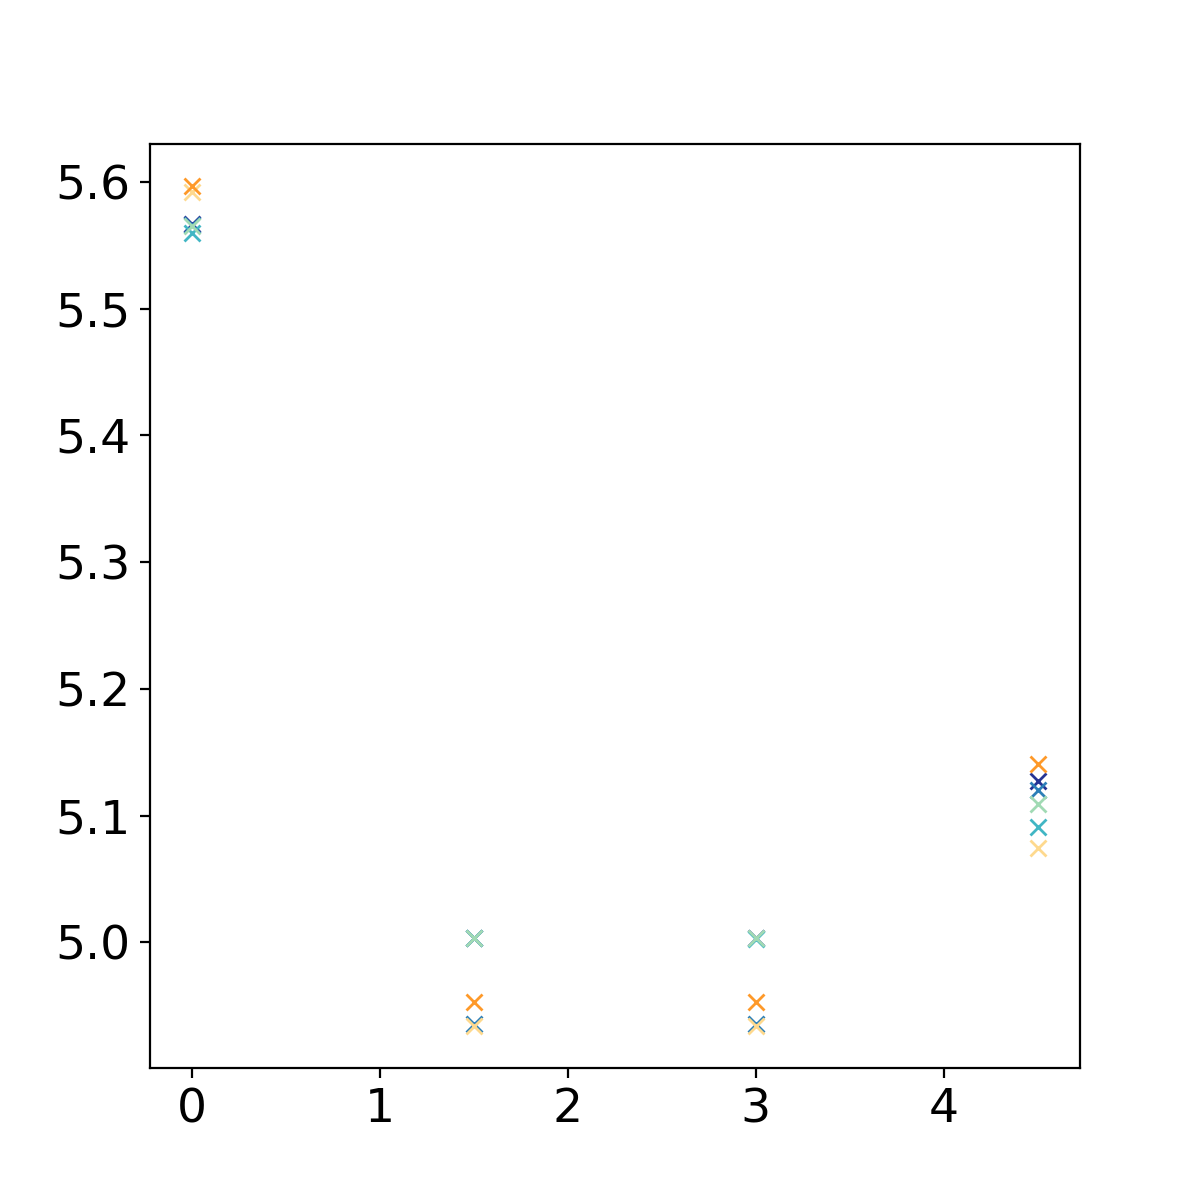

In [258]:
plt.figure()
offs0=0
offs1=1.5
offs2=3
offs3=4.5

subj_idx = 0
for subj in subjs:
  plt.plot(offs0, dists[atlases[0]][subj_idx],ls='',marker='x',color=interp_colors[subj_idx+1],label=f'{subj}')
  plt.plot(offs1, dists[atlases[1]][subj_idx],ls='',marker='x',color=interp_colors[subj_idx+1],label=f'{subj}')
  plt.plot(offs2, dists[atlases[2]][subj_idx],ls='',marker='x',color=interp_colors[subj_idx+1],label=f'{subj}')
  plt.plot(offs3, dists[atlases[3]][subj_idx],ls='',marker='x',color=interp_colors[subj_idx+1],label=f'{subj}')
  subj_idx += 1

In [281]:
a=torch.zeros((2,2,2,3,3))
b=torch.zeros((2,2,2,3,3))
a[:,:,:] = torch.eye(3)
b[:,:,:] = torch.eye(3)
a[:,:,:,0,0] = 3
b[:,:,:,0,0] = 6
c = np.exp(1.5)*a
d = np.exp(1.5)*b
print(a,b,c,d)

tensor([[[[[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]],


         [[[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]]],



        [[[[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]],


         [[[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[3., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]]]]) tensor([[[[[6., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[6., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]],


         [[[6., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]],

          [[6., 0., 0.],
           [0., 1., 0.],
           [0., 0., 1.]]]],



        [[[[6., 0., 0.],
           [0., 1., 0.],
          

In [280]:
from util.SplitEbinMetric3D import Squared_distance_Ebin
print(Squared_distance_Ebin(a,b,1./3.,torch.Tensor(np.ones((2,2,2)))))
print(Squared_distance_Ebin(c,d,1./3.,torch.Tensor(np.ones((2,2,2)))))
print(Squared_distance_Ebin(a,c,1./3.,torch.Tensor(np.ones((2,2,2)))))
print(Squared_distance_Ebin(b,d,1./3.,torch.Tensor(np.ones((2,2,2)))))

tensor(7.8972)
tensor(74.9267)
tensor(319.7912)
tensor(452.2531)


In [406]:
print(np.exp(1.5)**(3/2.)*7.8972)
print((2*2**(3/2.)-2**(3/2.)*27**(1/2.)/4)*319.7912)

74.92654744689054
634.0243123217818


# Plot distances between tractographies SAME SEEDS!!

In [359]:
bval = 'all'

use_corr_dist = False
hd_atlasname = 'BrainAtlasUkfBallImgMetDirectRegSept10'
kc_atlasname = 'Ball_met_img_rigid_6subj'
out_tract_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/{kc_atlasname}_and_subj_tracts/'

atlas_tract_dir = f'{out_tract_dir}atlas_tracts/'
#dtitk_atlas_tract_dir = f'{out_tract_dir}dtitk_atlas_tracts/'
dtitk_atlas_tract_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg/'
tracts_of_subjects_dir = f'{out_tract_dir}subj_tracts/'
phi_of_tracts_of_subjects_dir = f'{out_tract_dir}subj_tracts_deformed_to_atlas_space/'
tracts_of_phi_of_subjects_dir = f'{out_tract_dir}subj_tracts_computed_in_atlas_space/'
#tracts_of_dtitk_subjects_dir = f'{out_tract_dir}dtitk_subj_tracts/'
#phi_of_tracts_of_dtitk_subjects_dir = f'{out_tract_dir}subj_tracts_deformed_to_dtitk_atlas_space/'
#tracts_of_phi_of_dtitk_subjects_dir = f'{out_tract_dir}subj_tracts_computed_in_dtitk_atlas_space/'
tracts_of_dtitk_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg/'
phi_of_tracts_of_dtitk_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg/'
tracts_of_phi_of_dtitk_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/DTITKReg/'
pp=''
ext='vtp'
if use_corr_dist:
  ext='pkl.gz'

dtitkext='vtk'
#atlas_tract_dir = f'{out_tract_dir}atlas_tracts/Preprocessed_l20_lmax100/'
#dtitk_atlas_tract_dir = f'{out_tract_dir}dtitk_atlas_tracts/Preprocessed_l20_lmax100/'
#tracts_of_subjects_dir = f'{out_tract_dir}subj_tracts/Preprocessed_l20_lmax100/'
#phi_of_tracts_of_subjects_dir = f'{out_tract_dir}subj_tracts_deformed_to_atlas_space/Preprocessed_l20_lmax100/'
#tracts_of_phi_of_subjects_dir = f'{out_tract_dir}subj_tracts_computed_in_atlas_space/Preprocessed_l20_lmax100/'
#pp='_pp'
#distances_fname = f"{out_tract_dir}distances_ppf_10.pkl"
#with open(distances_fname, 'rb') as f:
#  distances_10 = pickle.load(f)

#distances_fname = f"{out_tract_dir}distances_ppf_40.pkl"
#with open(distances_fname, 'rb') as f:
#  distances_40 = pickle.load(f)

#distances_fname = f"{out_tract_dir}distances_ppf_100.pkl"
if use_corr_dist:
  distances_fname = f"{out_tract_dir}geo_distances.pkl"
else:   
  distances_fname = f"{out_tract_dir}distances.pkl"
with open(distances_fname, 'rb') as f:
  distances = pickle.load(f)


#distances_fname = f"{out_tract_dir}distances.pkl"
#with open(distances_fname, 'rb') as f:
#  distances = pickle.load(f)
#distances = distances_geo

region_masks = []
single_masks = []

region_masks.append('CST_v3')
region_masks.append('Cing_cor_v3')
region_masks.append('SLF_v3')
single_masks.append('AC_v3_seed')
single_masks.append('CC_v3_seed')
single_masks.append('CC_genu_thick_seed')
single_masks.append('CC_genu_thin_seed')

subjs = []
subjs.append('105923')
subjs.append('108222')
subjs.append('102715')
subjs.append('100206')
subjs.append('104416')
subjs.append('107422')

if use_corr_dist:
  dist_idx = 0
else:
  dist_idx = 2 # 0 for my Hausdorff corresponding distance, 1 for my Hausdorff distance, 2 for wma distance
err_dist = -10 # setting to some value that is unreasonable and that will not be plotted

In [360]:
dist_Tdtitk_Tatlas = {}
#subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_all_geos_geodesics{pp}.vtp'
subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_whole_brain.vtk'
atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_all_geodesics{pp}.{ext}'
subj='dtitk'
dist_Tdtitk_Tatlas[subj] = {}
try:
  dist_Tdtitk_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
  if dist_Tdtitk_Tatlas[subj]['atlas'] < 0:
    print(subj_pd_fname+','+atlas_pd_fname, dist_Tdtitk_Tatlas[subj]['atlas'])
except Exception as err:
  print("Exception",err,"caught for", subj, "setting distance to", err_dist)
  dist_Tdtitk_Tatlas[subj]['atlas'] = err_dist
    
for rmask in region_masks:
  for hemi in ["hemi1", "hemi2"]:
    #subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
    subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{rmask}_{hemi}.vtk'
    atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
    try:  
      dist_Tdtitk_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Tdtitk_Tatlas[subj][rmask+"_"+hemi] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Tdtitk_Tatlas[subj][rmask+"_"+hemi])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Tdtitk_Tatlas[subj][rmask+"_"+hemi] = err_dist

for smask in single_masks:
  #subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{smask}_geodesics{pp}.vtp'
  subj_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{smask}.vtk'
  atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{smask}_geodesics{pp}.{ext}'
  try:
    dist_Tdtitk_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
    if dist_Tdtitk_Tatlas[subj][smask] < 0:
      print(subj_pd_fname+','+atlas_pd_fname, dist_Tdtitk_Tatlas[subj][smask])
  except Exception as err:
    print("Exception",err,"caught for", subj, "setting distance to", err_dist)
    dist_Tdtitk_Tatlas[subj][smask] = err_dist


In [361]:
dist_Ts_Tatlas = {}
for subj in subjs:
  subjname = subj + f'_{bval}_'  
  subj_pd_fname = tracts_of_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.{ext}'
  atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_all_geodesics{pp}.{ext}'
  dist_Ts_Tatlas[subj] = {}
  try:
    dist_Ts_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
    if dist_Ts_Tatlas[subj]['atlas'] < 0:
      print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj]['atlas'])
  except Exception as err:
    print("Exception",err,"caught for", subj, "setting distance to", err_dist)
    dist_Ts_Tatlas[subj]['atlas'] = err_dist
    
  for rmask in region_masks:
    for hemi in ["hemi1", "hemi2"]:
      subj_pd_fname = tracts_of_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
      atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
      try:  
        dist_Ts_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Ts_Tatlas[subj][rmask+"_"+hemi] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj][rmask+"_"+hemi])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Ts_Tatlas[subj][rmask+"_"+hemi] = err_dist

  for smask in single_masks:
    subj_pd_fname = tracts_of_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.{ext}'
    atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{smask}_geodesics{pp}.{ext}'
    try:
      dist_Ts_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Ts_Tatlas[subj][smask] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj][smask])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Ts_Tatlas[subj][smask] = err_dist


In [362]:
dist_Tds_Tdatlas = {}
for subj in subjs:
  subjname = subj + f'_{bval}_'  
  #subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.vtp'
  #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_all_geos_geodesics{pp}.vtp'
  subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subj}_whole_brain_in_subj_space.vtk'
  atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_whole_brain.vtk'
  dist_Tds_Tdatlas[subj] = {}
  try:
    dist_Tds_Tdatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
    if dist_Tds_Tdatlas[subj]['atlas'] < 0:
      print(subj_pd_fname+','+atlas_pd_fname, dist_Tds_Tdatlas[subj]['atlas'])
  except Exception as err:
    print("Exception",err,"caught for", subj, "setting distance to", err_dist)
    dist_Tds_Tdatlas[subj]['atlas'] = err_dist
    
  for rmask in region_masks:
    for hemi in ["hemi1", "hemi2"]:
      #subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
      #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
      subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subj}_{rmask}_{hemi}_in_subj_space.vtk'
      atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{rmask}_{hemi}.vtk'
      try:  
        dist_Tds_Tdatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Tds_Tdatlas[subj][rmask+"_"+hemi] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Tds_Tdatlas[subj][rmask+"_"+hemi])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Tds_Tdatlas[subj][rmask+"_"+hemi] = err_dist

  for smask in single_masks:
    #subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.vtp'
    #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{smask}_geodesics{pp}.vtp'
    subj_pd_fname = tracts_of_dtitk_subjects_dir + f'{subj}_{smask}_in_subj_space.vtk'
    atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{smask}.vtk'
    try:
      dist_Tds_Tdatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Tds_Tdatlas[subj][smask] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Tds_Tdatlas[subj][smask])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Tds_Tdatlas[subj][smask] = err_dist


In [363]:
dist_Tps_Tatlas = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.{ext}'
    atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_all_geodesics{pp}.{ext}'
    dist_Tps_Tatlas[subj] = {}
    try:
      dist_Tps_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Tps_Tatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Tps_Tatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        try:
          dist_Tps_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_Tps_Tatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_Tps_Tatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.{ext}'
      atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{smask}_geodesics{pp}.{ext}'
      try:
        dist_Tps_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Tps_Tatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Tps_Tatlas[subj][smask] = err_dist


In [364]:
dist_Tpds_Tdatlas = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    #subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.vtp'
    #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_all_geos_geodesics{pp}.vtp'
    subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_whole_brain_in_atlas_space.vtk'
    atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_whole_brain.vtk'
    dist_Tpds_Tdatlas[subj] = {}
    try:
      dist_Tpds_Tdatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Tpds_Tdatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Tpds_Tdatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Tpds_Tdatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        #subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_{rmask}_{hemi}_in_atlas_space.vtk'
        atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{rmask}_{hemi}.vtk'
        try:
          dist_Tpds_Tdatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_Tpds_Tdatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_Tpds_Tdatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_Tpds_Tdatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      #subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.vtp'
      #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{smask}_geodesics{pp}.vtp'
      subj_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_{smask}_in_atlas_space.vtk'
      atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{smask}.vtk'
      try:
        dist_Tpds_Tdatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Tpds_Tdatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Tpds_Tdatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Tpds_Tdatlas[subj][smask] = err_dist


In [365]:
dist_pTs_Tatlas = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.{ext}'
    atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_all_geodesics{pp}.{ext}'
    dist_pTs_Tatlas[subj] = {}
    try:
      dist_pTs_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_pTs_Tatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_pTs_Tatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        try:
          dist_pTs_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_pTs_Tatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_pTs_Tatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.{ext}'
      atlas_pd_fname = atlas_tract_dir + f'{kc_atlasname}_geos_{smask}_geodesics{pp}.{ext}'
      try:
        dist_pTs_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_pTs_Tatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_pTs_Tatlas[subj][smask] = err_dist


In [366]:
dist_pTds_Tdatlas = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.vtp'
    #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_all_geos_geodesics{pp}.vtp'
    subj_pd_fname =  phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_whole_brain_to_atlas_space.vtk'
    atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_whole_brain.vtk'
    dist_pTds_Tdatlas[subj] = {}
    try:
      dist_pTds_Tdatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_pTds_Tdatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tdatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_pTds_Tdatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_{rmask}_{hemi}_to_atlas_space.vtk'
        atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{rmask}_{hemi}.vtk'
        try:
          dist_pTds_Tdatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_pTds_Tdatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tdatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_pTds_Tdatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.vtp'
      #atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_geos_{smask}_geodesics{pp}.vtp'
      subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_{smask}_to_atlas_space.vtk'
      atlas_pd_fname = dtitk_atlas_tract_dir + f'dtitk_atlas_{smask}.vtk'
      try:
        dist_pTds_Tdatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_pTds_Tdatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tdatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_pTds_Tdatlas[subj][smask] = err_dist


In [367]:
dist_pTs_Tps = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.{ext}'
    atlas_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.{ext}'
    dist_pTs_Tps[subj] = {}
    try:
      dist_pTs_Tps[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_pTs_Tps[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tps[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_pTs_Tps[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        atlas_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.{ext}'
        try:
          dist_pTs_Tps[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_pTs_Tps[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tps[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_pTs_Tps[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.{ext}'
      atlas_pd_fname = tracts_of_phi_of_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.{ext}'
      try:
        dist_pTs_Tps[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_pTs_Tps[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tps[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_pTs_Tps[subj][smask] = err_dist


In [368]:
dist_pTds_Tpds = {}
for subj in subjs:
    subjname = subj + f'_{bval}_'  
    #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.vtp'
    #atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_all_geos_geodesics{pp}.vtp'
    subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_whole_brain_to_atlas_space.vtk'
    atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_whole_brain_in_atlas_space.vtk'
    dist_pTds_Tpds[subj] = {}
    try:
      dist_pTds_Tpds[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_pTds_Tpds[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tpds[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_pTds_Tpds[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        #atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_geos_{rmask}_{hemi}_geodesics{pp}.vtp'
        subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_{rmask}_{hemi}_to_atlas_space.vtk'
        atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_{rmask}_{hemi}_in_atlas_space.vtk'
        try:
          dist_pTds_Tpds[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_pTds_Tpds[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tpds[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_pTds_Tpds[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      #subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.vtp'
      #atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subjname}_geos_{smask}_geodesics{pp}.vtp'
      subj_pd_fname = phi_of_tracts_of_dtitk_subjects_dir + f'{subj}_{smask}_to_atlas_space.vtk'
      atlas_pd_fname = tracts_of_phi_of_dtitk_subjects_dir + f'{subj}_{smask}_in_atlas_space.vtk'
      try:
        dist_pTds_Tpds[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_pTds_Tpds[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_pTds_Tpds[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_pTds_Tpds[subj][smask] = err_dist


# Save results from geo_distances into *_corr structures, then run above again using wma distances

In [369]:
#dist_Ts_Tatlas_10 = dist_Ts_Tatlas
#dist_Tdtitk_Tatlas_10 = dist_Tdtitk_Tatlas
#dist_Tps_Tatlas_10 = dist_Tps_Tatlas
#dist_pTs_Tatlas_10 = dist_pTs_Tatlas
#dist_pTs_Tps_10 = dist_pTs_Tps
#dist_Ts_Tatlas_40 = dist_Ts_Tatlas
#dist_Tdtitk_Tatlas_40 = dist_Tdtitk_Tatlas
#dist_Tps_Tatlas_40 = dist_Tps_Tatlas
#dist_pTs_Tatlas_40 = dist_pTs_Tatlas
#dist_pTs_Tps_40 = dist_pTs_Tps
#dist_Ts_Tatlas_100 = dist_Ts_Tatlas
#dist_Tdtitk_Tatlas_100 = dist_Tdtitk_Tatlas
#dist_Tps_Tatlas_100 = dist_Tps_Tatlas
#dist_pTs_Tatlas_100 = dist_pTs_Tatlas
#dist_pTs_Tps_comp = dist_pTs_Tps
#dist_Ts_Tatlas_comp = dist_Ts_Tatlas
#dist_Tdtitk_Tatlas_comp = dist_Tdtitk_Tatlas
#dist_Tps_Tatlas_comp = dist_Tps_Tatlas
#dist_pTs_Tatlas_comp = dist_pTs_Tatlas
#dist_pTs_Tps_comp = dist_pTs_Tps
if use_corr_dist:
  dist_pTs_Tps_corr = dist_pTs_Tps
  dist_Ts_Tatlas_corr = dist_Ts_Tatlas
  dist_Tdtitk_Tatlas_corr = dist_Tdtitk_Tatlas
  dist_Tps_Tatlas_corr = dist_Tps_Tatlas
  dist_pTs_Tatlas_corr = dist_pTs_Tatlas
  dist_pTs_Tps_corr = dist_pTs_Tps

In [382]:
fig_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/figures/'
do_save=False

In [371]:
plot_dist_compare=False

<IPython.core.display.Javascript object>


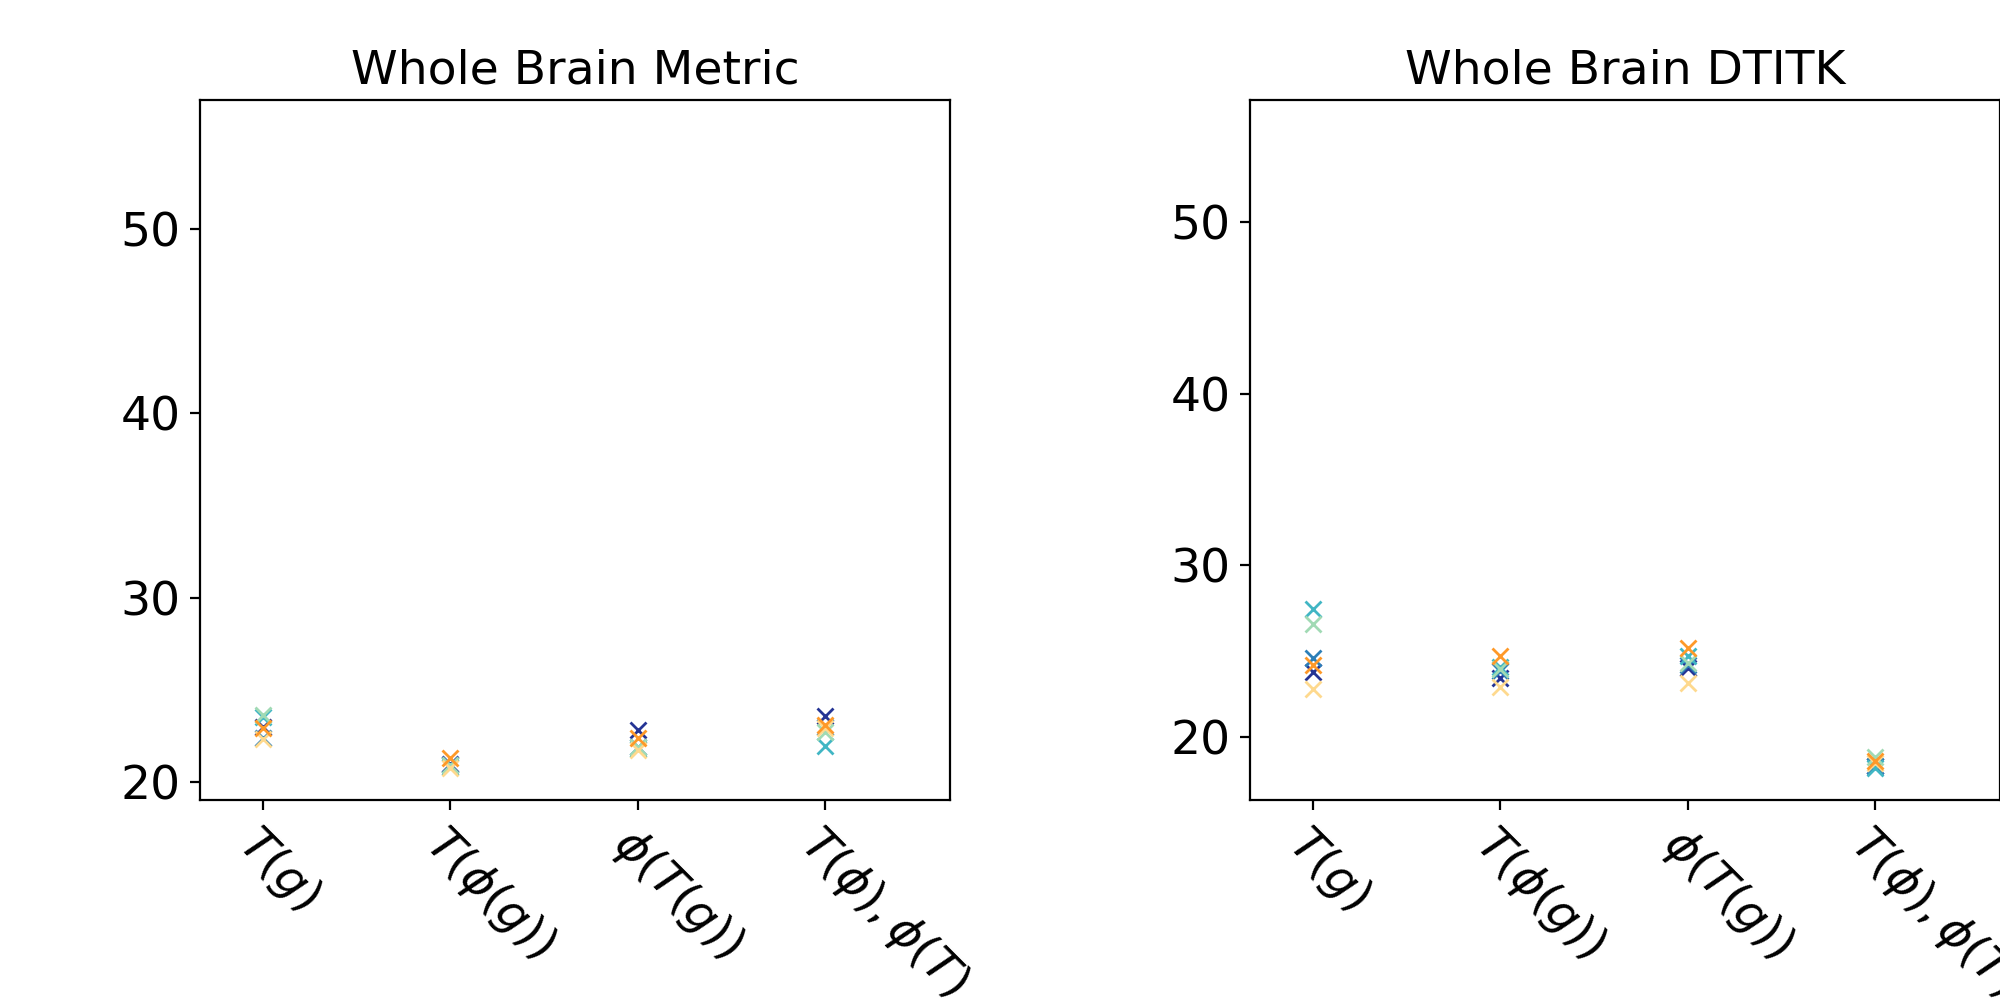

In [376]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain Metric', 'Whole Brain DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [4,10**4] # right, bottom

dist_fig=plt.figure(figsize=(10,5))
rows = 1
cols = 2 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=0.8, left=0.3, wspace=0.4, hspace=0.1)
grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.2, right=1, left=0.1, wspace=0.4, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
allax = [ax00,ax01]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
ax_idx=0
plt.sca(allax[ax_idx])
subj_idx=0
subj='dtitk'
plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
if plot_dist_compare:
  plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')

subj_idx=1
for subj in dist_Ts_Tatlas:
  plt.plot(Ts_offs,dist_Ts_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(Tps_offs,dist_Tps_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_offs,dist_pTs_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_Tps_offs,dist_pTs_Tps[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  if plot_dist_compare:
    plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
     
  subj_idx+=1 

ax_idx=1
plt.sca(allax[ax_idx])
subj_idx=0
subj='dtitk'
plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
if plot_dist_compare:
  plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')

subj_idx=1
for subj in dist_Tds_Tdatlas:
  plt.plot(Ts_offs,dist_Tds_Tdatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(Tps_offs,dist_Tpds_Tdatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_offs,dist_pTds_Tdatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_Tps_offs,dist_pTds_Tpds[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  if plot_dist_compare:
    plt.plot(Ts_offs,dist_Tds_Tdatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(Tps_offs,dist_Tpds_Tdatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_offs,dist_pTds_Tadtlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_Tps_offs,dist_pTds_Tpds_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
     
  subj_idx+=1 


axcnt = 0
for ax in allax:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([10**4,maxy*2])
  #plt.ylim([10**4.4,10**4.7])
  #plt.ylim([0,15]) 
  #plt.xlim([-0.5,7])
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pt[0], label_pt[1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs,Td_offs])
  #ax.set_xticklabels(['$T(g)$','$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$','T(dtitk)'])
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs])
  ax.set_xticklabels(['$T(g)$','$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  ax.set_rasterization_zorder(-5)
    
  axcnt += 1

if do_save:
  plt.gcf().savefig(fig_dir + 'whole_brain_tract_wma_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


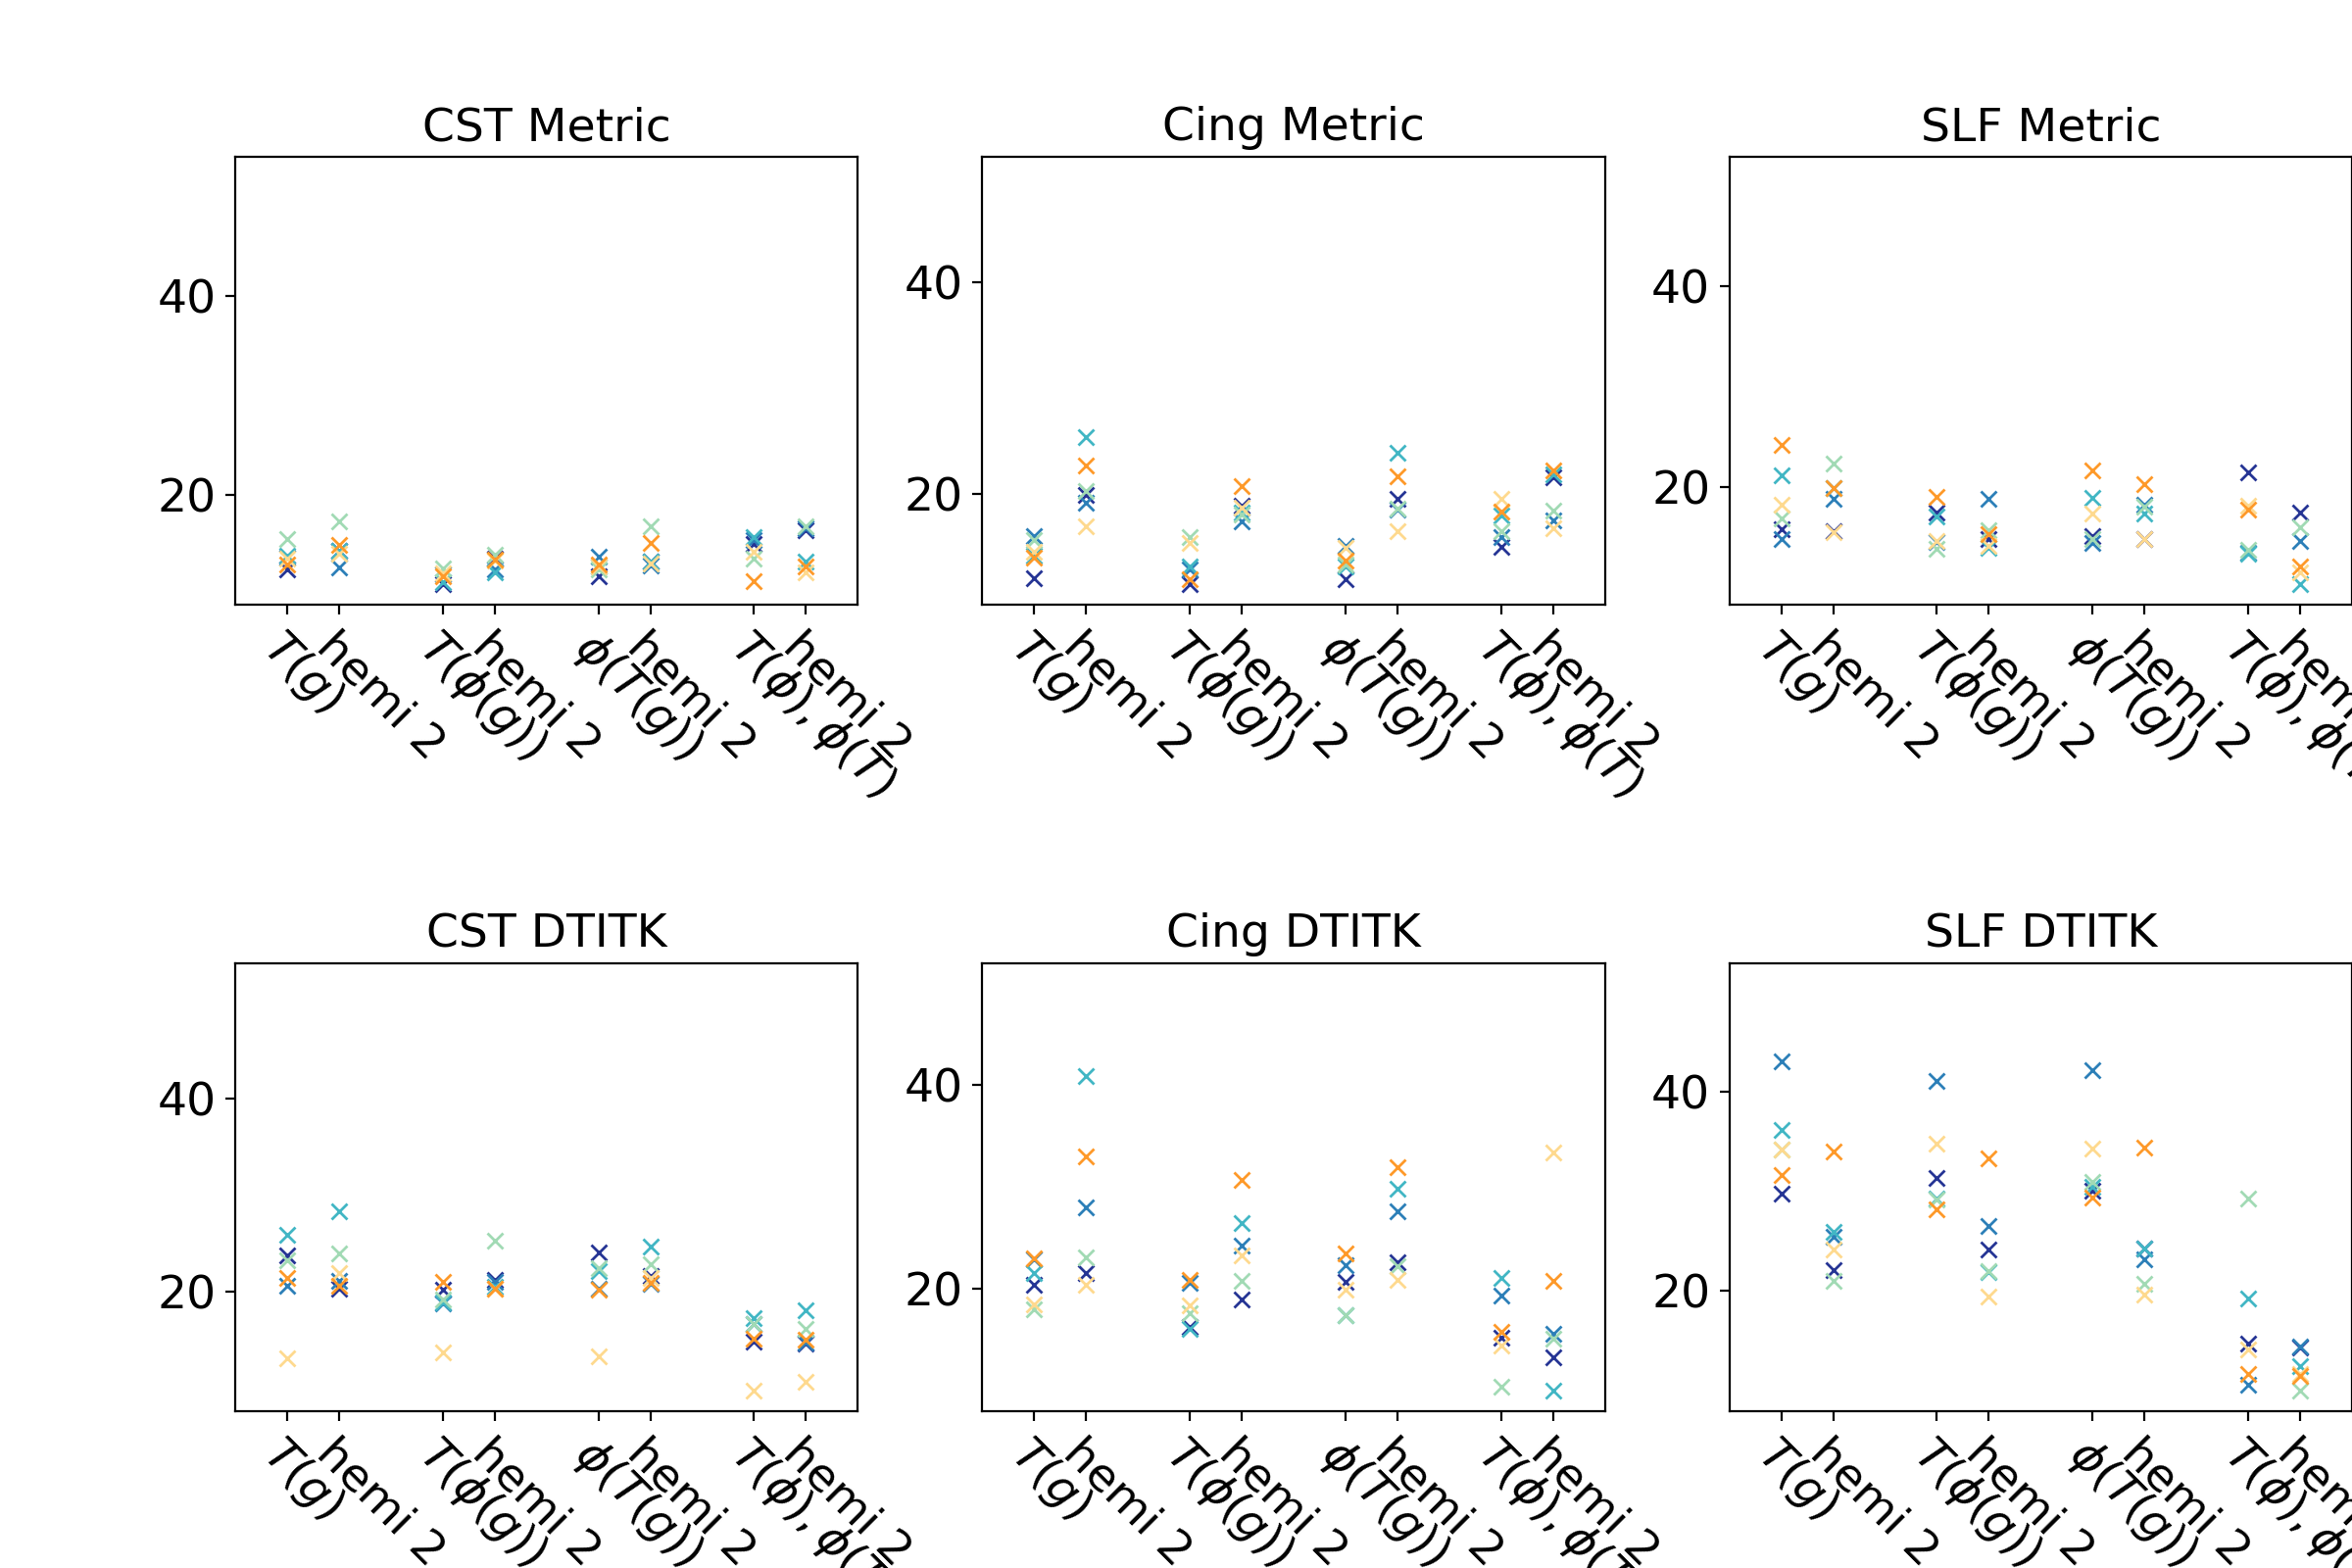

In [377]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
ax_labels = ['CST Metric', 'Cing Metric', 'SLF Metric',
             'CST DTITK', 'Cing DTITK', 'SLF DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [4,10**3] # right, bottom

dist_fig=plt.figure(figsize=(12,8))
rows = 2
cols = 3 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=1, left=0.1, wspace=0.4, hspace=0.8)

grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.1, right=1, left=0.1, wspace=0.2, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
ax10 = plt.subplot(grid[1,0])
ax11 = plt.subplot(grid[1,1])
ax12 = plt.subplot(grid[1,2])
allax_met = [ax00,ax01,ax02]
allax_dtitk = [ax10,ax11,ax12]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
subj_idx=0
subj='dtitk'
ax_idx=0
for rmask in region_masks:
  plt.sca(allax_met[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
  plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
 
  plt.sca(allax_dtitk[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
  plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
  ax_idx+=1

subj_idx=1
for subj in dist_Ts_Tatlas:
  ax_idx=0
  for rmask in region_masks:
    plt.sca(allax_met[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTs_Tps[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTs_Tps_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')

    plt.sca(allax_dtitk[ax_idx])
    plt.plot(Ts_offs,dist_Tds_Tdatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Ts_offs+hemi2_offs,dist_Tds_Tdatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(Tps_offs,dist_Tpds_Tdatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Tps_offs+hemi2_offs,dist_Tpds_Tdatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_offs,dist_pTds_Tdatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_offs+hemi2_offs,dist_pTds_Tdatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_Tps_offs,dist_pTds_Tpds[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTds_Tpds[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Tds_Tdatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Ts_offs+hemi2_offs,dist_Tds_Tdatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(Tps_offs,dist_Tpds_Tdatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Tps_offs+hemi2_offs,dist_Tpds_Tdatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_offs,dist_pTds_Tdatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_offs+hemi2_offs,dist_pTds_Tdatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_Tps_offs,dist_pTds_Tpds_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTds_Tpds_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    ax_idx+=1
        
  subj_idx+=1 

label_pts = [[2.5,10000],[2.5,40000],[2.5,60000]] # right, bottom
lidx=0
axcnt = 0
for ax in allax_met + allax_dtitk:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([10**3,10**5])
  #plt.ylim([0,15])
  #plt.ylim([0,50])
  #plt.xlim([-0.5,7]) # include dist to dtitk atlas
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs,pTs_Tps_offs,pTs_Tps_offs+hemi2_offs,Td_offs,Td_offs+hemi2_offs])
  #ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2','$T(\phi),\phi(T)$','hemi 2','T(dtitk)','hemi 2'])
  ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs,pTs_Tps_offs,pTs_Tps_offs+hemi2_offs])
  ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2','$T(\phi),\phi(T)$','hemi 2'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 1:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
    
  lidx += 1  
  axcnt += 1
 
if do_save:
  plt.gcf().savefig(fig_dir + 'region_tracts_wma_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


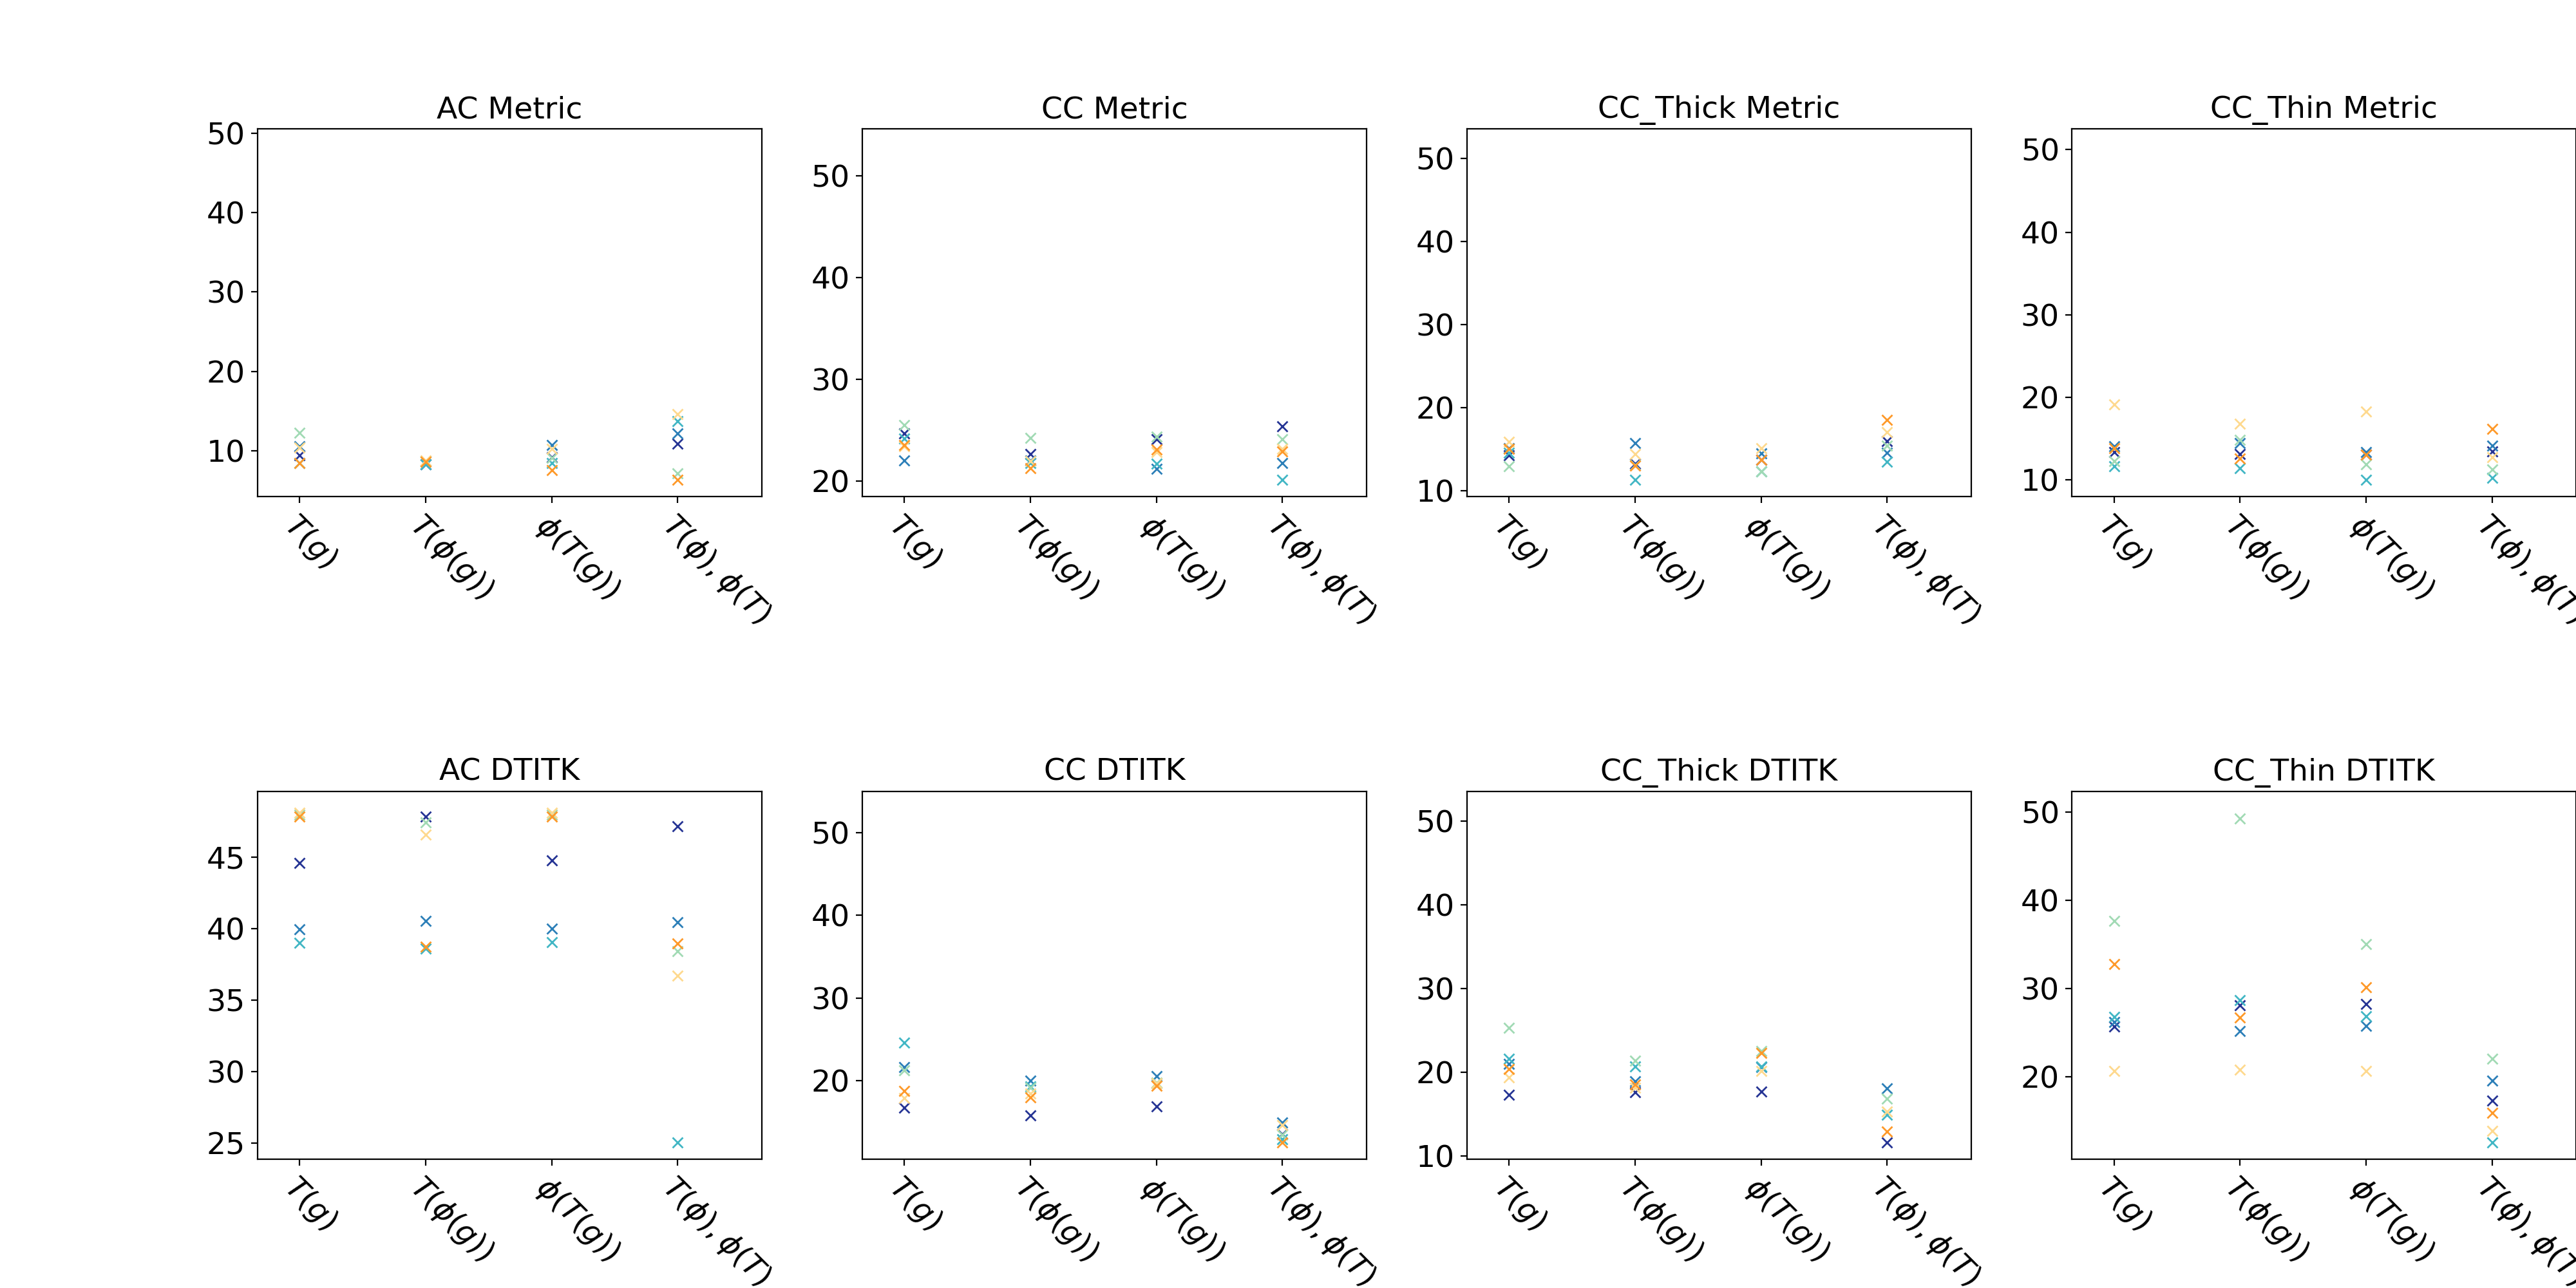

In [378]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_Thin']
ax_labels = ['AC Metric', 'CC Metric', 'CC_Thick Metric', 'CC_Thin Metric', 
             'AC DTITK', 'CC DTITK', 'CC_Thick DTITK', 'CC_Thin DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,2250] # right, bottom

dist_fig=plt.figure(figsize=(20,10))
rows = 2
cols = 4 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=1, left=0.1, wspace=0.5, hspace=0.1)
grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.1, right=1, left=0.1, wspace=0.2, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
ax03 = plt.subplot(grid[0,3])
ax10 = plt.subplot(grid[1,0])
ax11 = plt.subplot(grid[1,1])
ax12 = plt.subplot(grid[1,2])
ax13 = plt.subplot(grid[1,3])
allax_met = [ax00,ax01,ax02,ax03]
allax_dtitk = [ax10,ax11,ax12,ax13]
#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
subj_idx=0
subj='dtitk'
ax_idx=0
for smask in single_masks:
  plt.sca(allax_met[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  plt.sca(allax_dtitk[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  ax_idx+=1

subj_idx=1
for subj in dist_Ts_Tatlas:
  ax_idx=0
        
  for smask in single_masks:
    plt.sca(allax_met[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.sca(allax_dtitk[ax_idx])
    plt.plot(Ts_offs,dist_Tds_Tdatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(Tps_offs,dist_Tpds_Tdatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_offs,dist_pTds_Tdatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_Tps_offs,dist_pTds_Tpds[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Tds_Tdatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(Tps_offs,dist_Tpds_Tdatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_offs,dist_pTds_Tdatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_Tps_offs,dist_pTds_Tpds_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    ax_idx+=1
    
  subj_idx+=1 

axcnt = 0
label_pts = [[2.5,2250],[2.5,700000],[2.5,120000],[2.5,40000]] # right, bottom
lidx=0
for ax in allax_met + allax_dtitk:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([1,10**5])
  #plt.ylim([0,50])
  #plt.xlim([-0.5,7])
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs,Td_offs])
  #ax.set_xticklabels(['$T(g)$', '$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$','T(dtitk)'])
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs])
  ax.set_xticklabels(['$T(g)$', '$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 4:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
  lidx += 1  
  axcnt += 1

if do_save:
  plt.gcf().savefig(fig_dir + 'single_tracts_wma_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


# Plot Distances Between Corresponding Geodesics

<IPython.core.display.Javascript object>


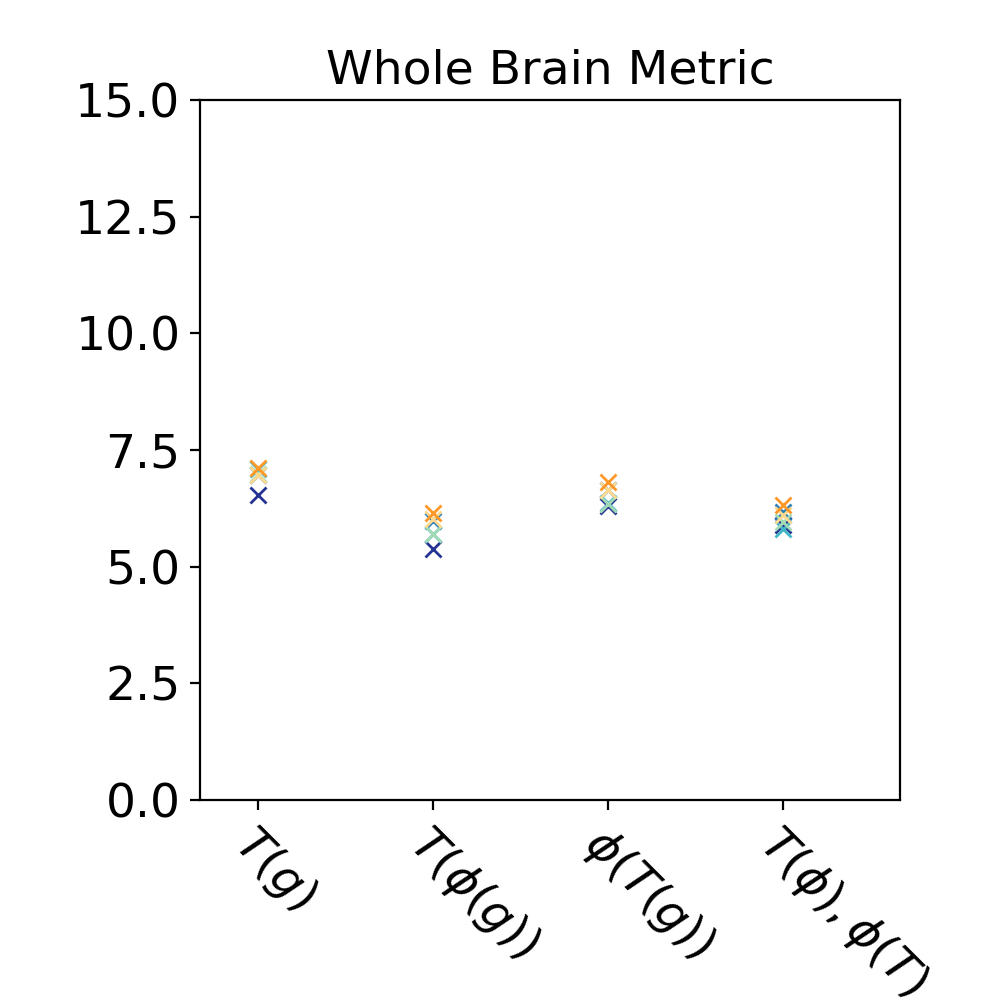

In [379]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain Metric', 'Whole Brain DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [4,10**4] # right, bottom

dist_fig=plt.figure(figsize=(5,5))
rows = 1
cols = 1 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=0.8, left=0.3, wspace=0.4, hspace=0.1)
grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.2, right=0.9, left=0.2, wspace=0.4, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
#ax01 = plt.subplot(grid[0,1])
allax = [ax00]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
ax_idx=0
plt.sca(allax[ax_idx])
subj_idx=0
subj='dtitk'
plt.plot(Td_offs,dist_Tdtitk_Tatlas_corr[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
if plot_dist_compare:
  plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')

subj_idx=1
for subj in dist_Ts_Tatlas:
  plt.plot(Ts_offs,dist_Ts_Tatlas_corr[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(Tps_offs,dist_Tps_Tatlas_corr[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_offs,dist_pTs_Tatlas_corr[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_Tps_offs,dist_pTs_Tps_corr[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  if plot_dist_compare:
    plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj]['atlas'],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
     
  subj_idx+=1 

axcnt = 0
for ax in allax:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([10**4,maxy*2])
  #plt.ylim([10**4.4,10**4.7])
  plt.ylim([0,15]) 
  #plt.xlim([-0.5,7])
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pt[0], label_pt[1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs,Td_offs])
  #ax.set_xticklabels(['$T(g)$','$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$','T(dtitk)'])
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs])
  ax.set_xticklabels(['$T(g)$','$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  ax.set_rasterization_zorder(-5)
    
  axcnt += 1

if do_save:
  plt.gcf().savefig(fig_dir + 'whole_brain_tract_corresp_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


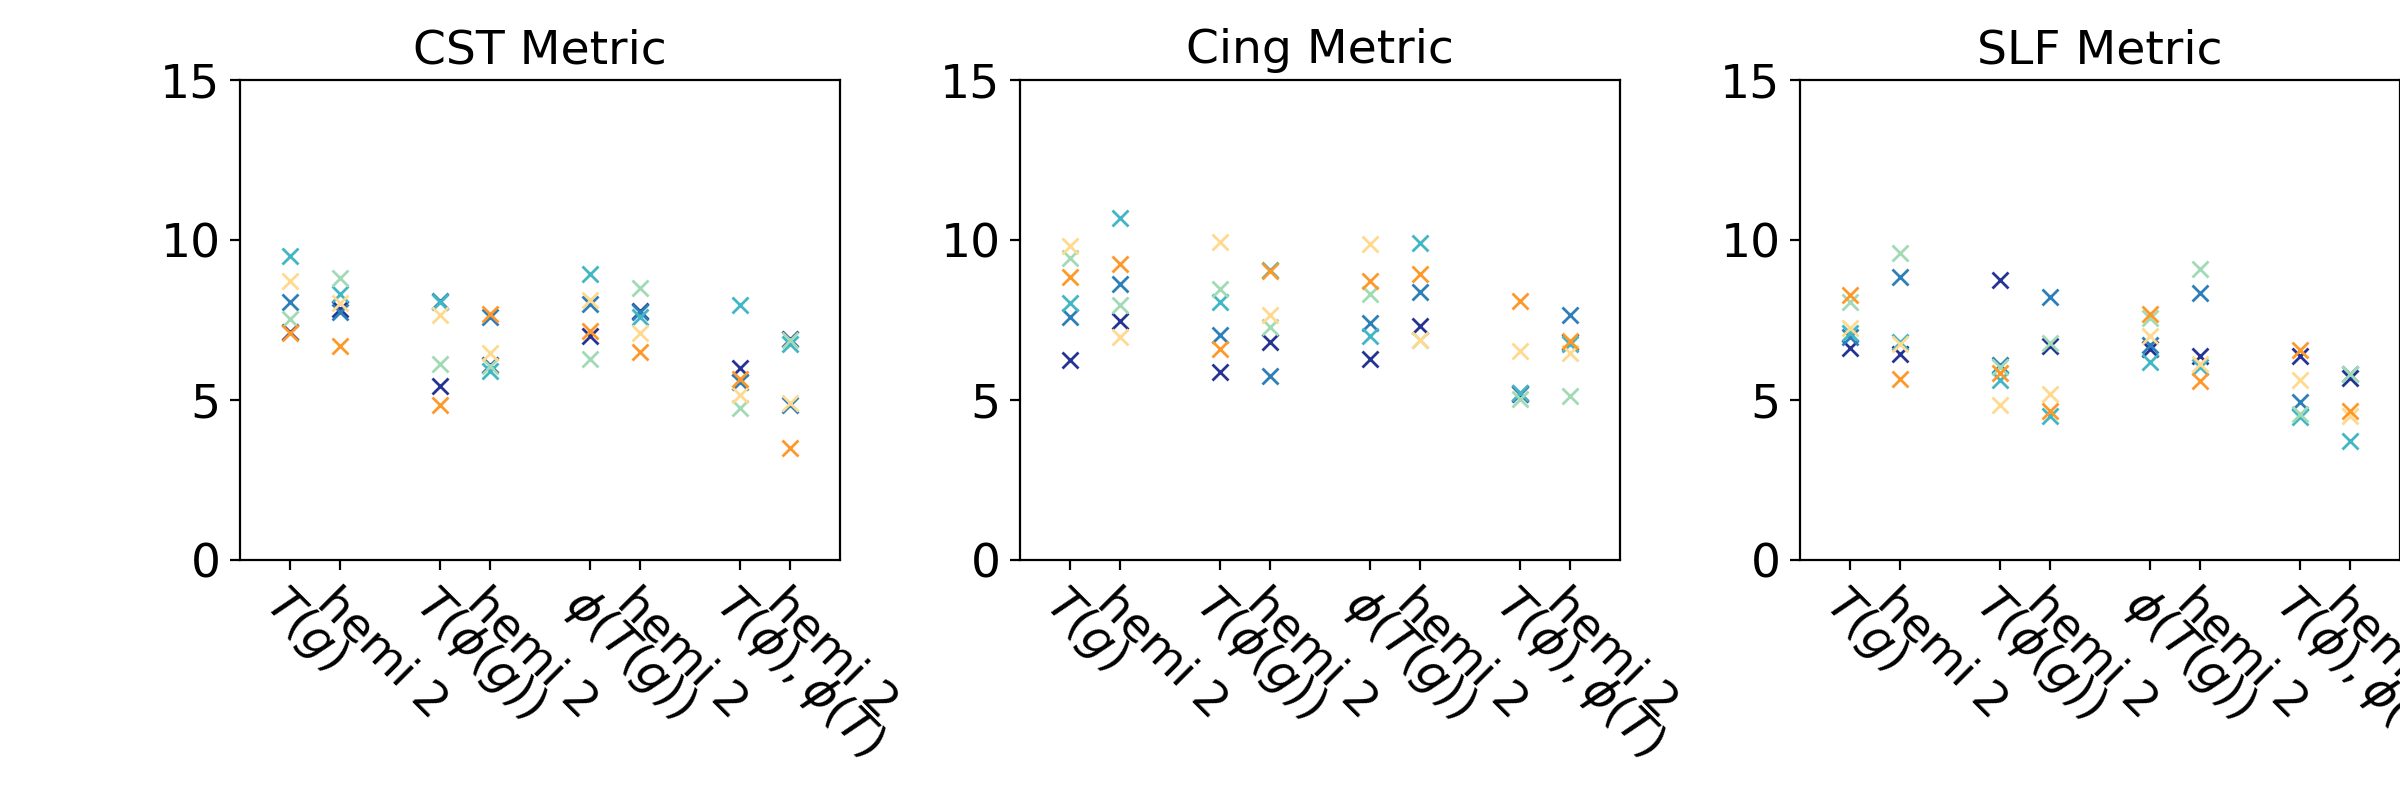

In [380]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
ax_labels = ['CST Metric', 'Cing Metric', 'SLF Metric',
             'CST DTITK', 'Cing DTITK', 'SLF DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [4,10**3] # right, bottom

dist_fig=plt.figure(figsize=(12,4))
rows = 1
cols = 3 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=1, left=0.1, wspace=0.4, hspace=0.8)

grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.3, right=1, left=0.1, wspace=0.3, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
#ax10 = plt.subplot(grid[1,0])
#ax11 = plt.subplot(grid[1,1])
#ax12 = plt.subplot(grid[1,2])
allax_met = [ax00,ax01,ax02]
#allax_dtitk = [ax10,ax11,ax12]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
subj_idx=0
subj='dtitk'
ax_idx=0
for rmask in region_masks:
  plt.sca(allax_met[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas_corr[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
  plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas_corr[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Td_offs+hemi2_offs,dist_Tdtitk_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
  ax_idx+=1

subj_idx=1
for subj in dist_Ts_Tatlas:
  ax_idx=0
  for rmask in region_masks:
    plt.sca(allax_met[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas_corr[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas_corr[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(Tps_offs,dist_Tps_Tatlas_corr[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas_corr[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_offs,dist_pTs_Tatlas_corr[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas_corr[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps_corr[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTs_Tps_corr[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
      plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj][rmask+"_hemi1"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
      plt.plot(pTs_Tps_offs+hemi2_offs,dist_pTs_Tps_comp[subj][rmask+"_hemi2"],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')

    ax_idx+=1
        
  subj_idx+=1 

label_pts = [[2.5,10000],[2.5,40000],[2.5,60000]] # right, bottom
lidx=0
axcnt = 0
for ax in allax_met:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([10**3,10**5])
  plt.ylim([0,15])
  #plt.ylim([0,10000])
  #plt.xlim([-0.5,7]) # include dist to dtitk atlas
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs,pTs_Tps_offs,pTs_Tps_offs+hemi2_offs,Td_offs,Td_offs+hemi2_offs])
  #ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2','$T(\phi),\phi(T)$','hemi 2','T(dtitk)','hemi 2'])
  ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs,pTs_Tps_offs,pTs_Tps_offs+hemi2_offs])
  ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2','$T(\phi),\phi(T)$','hemi 2'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 1:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
    
  lidx += 1  
  axcnt += 1
 
if do_save:
  plt.gcf().savefig(fig_dir + 'region_tracts_corresp_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)


<IPython.core.display.Javascript object>


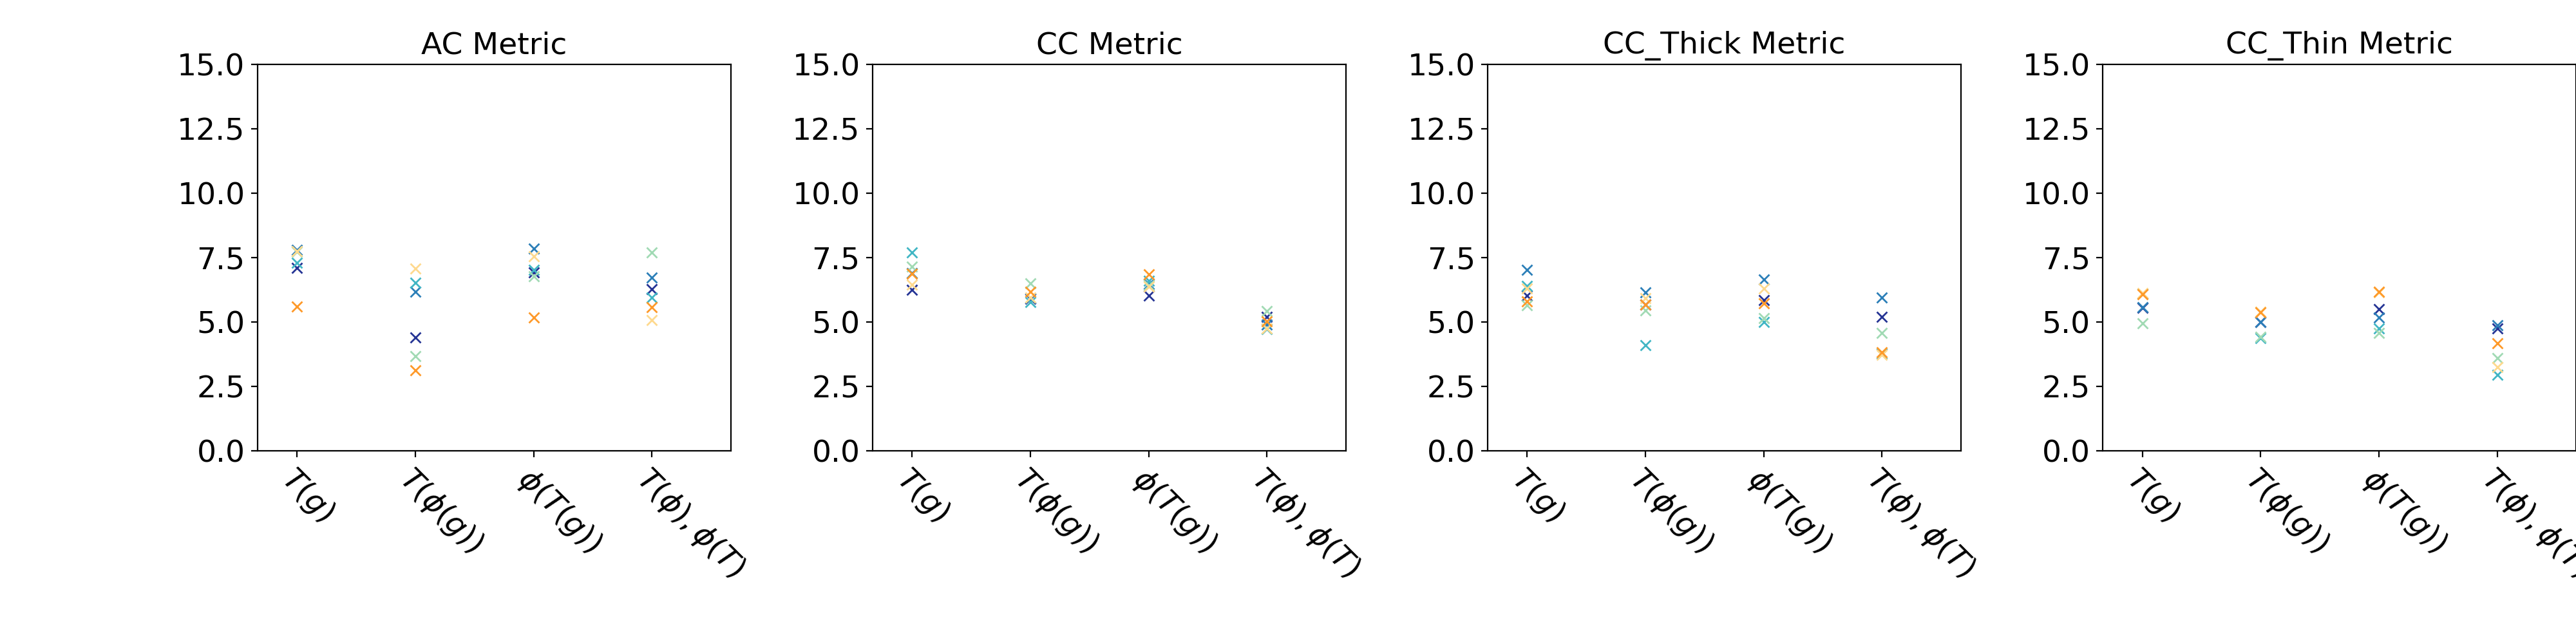

In [381]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_Thin']
ax_labels = ['AC Metric', 'CC Metric', 'CC_Thick Metric', 'CC_Thin Metric', 
             'AC DTITK', 'CC DTITK', 'CC_Thick DTITK', 'CC_Thin DTITK']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,2250] # right, bottom

dist_fig=plt.figure(figsize=(20,5))
rows = 1
cols = 4 

#grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.4, right=1, left=0.1, wspace=0.5, hspace=0.1)
grid = plt.GridSpec(rows, cols, top=0.9, bottom=0.3, right=1, left=0.1, wspace=0.3, hspace=0.8)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
ax03 = plt.subplot(grid[0,3])
#ax10 = plt.subplot(grid[1,0])
#ax11 = plt.subplot(grid[1,1])
#ax12 = plt.subplot(grid[1,2])
#ax13 = plt.subplot(grid[1,3])
allax_met = [ax00,ax01,ax02,ax03]
#allax_dtitk = [ax10,ax11,ax12,ax13]
#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
pTs_Tps_offs=4.5
Td_offs=6
subj_idx=0
subj='dtitk'
ax_idx=0
for smask in single_masks:
  plt.sca(allax_met[ax_idx])
  plt.plot(Td_offs,dist_Tdtitk_Tatlas_corr[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  if plot_dist_compare:
    plt.plot(Td_offs,dist_Tdtitk_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
  ax_idx+=1

subj_idx=1
for subj in dist_Ts_Tatlas:
  ax_idx=0
        
  for smask in single_masks:
    plt.sca(allax_met[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas_corr[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(Tps_offs,dist_Tps_Tatlas_corr[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_offs,dist_pTs_Tatlas_corr[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_Tps_offs,dist_pTs_Tps_corr[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    if plot_dist_compare:
      plt.plot(Ts_offs,dist_Ts_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(Tps_offs,dist_Tps_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_offs,dist_pTs_Tatlas_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
      plt.plot(pTs_Tps_offs,dist_pTs_Tps_comp[subj][smask],ls='',marker='.',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    ax_idx+=1
    
  subj_idx+=1 

axcnt = 0
label_pts = [[2.5,2250],[2.5,700000],[2.5,120000],[2.5,40000]] # right, bottom
lidx=0
for ax in allax_met:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([1,10**5])
  plt.ylim([0,15])
  #plt.xlim([-0.5,7])
  plt.xlim([-0.5,5.5])
    
  #t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
  ax.set_title(ax_labels[axcnt])  
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  #ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs,Td_offs])
  #ax.set_xticklabels(['$T(g)$', '$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$','T(dtitk)'])
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs,pTs_Tps_offs])
  ax.set_xticklabels(['$T(g)$', '$T(\phi(g))$','$\phi(T(g))$','$T(\phi),\phi(T)$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 4:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
  lidx += 1  
  axcnt += 1

if do_save:
  plt.gcf().savefig(fig_dir + 'single_tracts_corresp_dist.png', 
                    bbox_inches='tight', pad_inches=0, dpi=400, transparent=True)

<IPython.core.display.Javascript object>


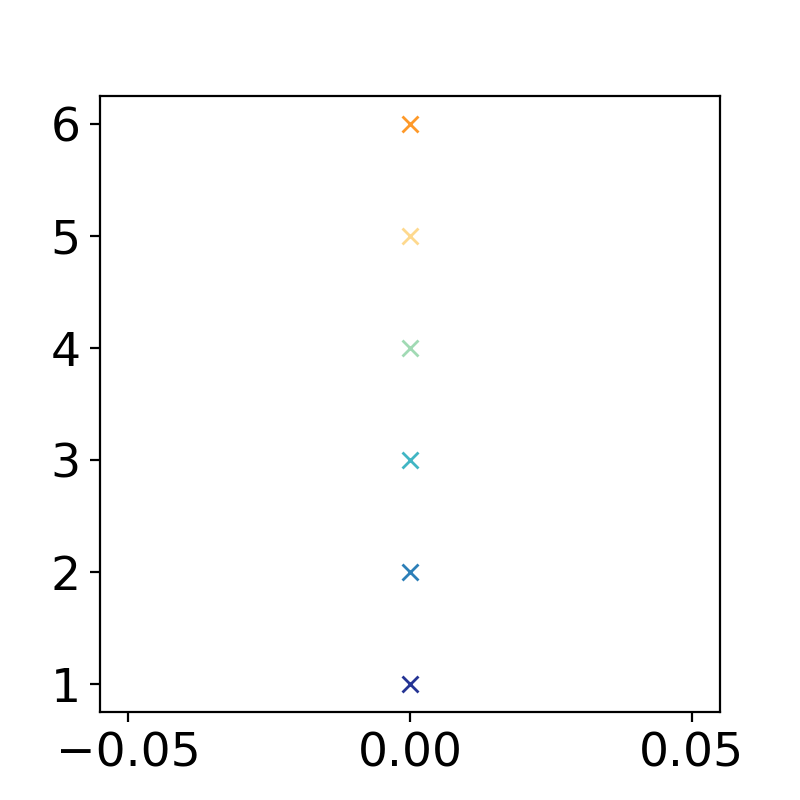

In [226]:
plt.figure()
for x in range(1,7):
  plt.plot(x,color=interp_colors[x],marker='x',ls='')
plt.show()

# Plot distances between tractographies DIFFERENT SEEDS!!

In [203]:
bval = 'all'
atlas = 'BrainAtlasUkfBallImgMetDirectRegSept10'
atlas_pref = 'Ball_met_img_rigid_6subj'
results_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/'

  
atlas_dir = f'/home/sci/hdai/Projects/Atlas3D/output/{atlas}/'
atlas_tract_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/{atlas_pref}/Preprocessed_100k_all/'
tracts_of_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/b{bval}_UKF_orig_scaled_tens_rreg/Preprocessed_100k_all/'
phi_of_tracts_of_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/b{bval}_UKF_orig_scaled_tens_rreg/tfmed_to_{atlas}/Preprocessed_100k/'
tracts_of_phi_of_subjects_dir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/b{bval}_UKF_orig_scaled_tens_rreg_atlas_space/Preprocessed_100k/'
distances_fname = f"{results_dir}distances.pkl"
with open(distances_fname, 'rb') as f:
  distances = pickle.load(f)

region_masks = []
single_masks = []

region_masks.append('CST_v3')
region_masks.append('Cing_cor_v3')
region_masks.append('SLF_v3')
single_masks.append('AC_v3_seed')
single_masks.append('CC_v3_seed')
single_masks.append('CC_genu_thick_seed')
single_masks.append('CC_genu_thin_seed')

subjs = []
subjs.append('105923')
subjs.append('108222')
subjs.append('102715')
subjs.append('100206')
subjs.append('104416')
subjs.append('107422')

dist_idx = 1 # 0 for my Hausdorff distance, 1 for wma distance
err_dist = -10 # setting to some value that is unreasonable and that will not be plotted

## Plot distances between T(s) and T(atlas)

In [204]:
dist_Ts_Tatlas = {}
atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geodesics_pp.vtp'
for subj in subjs:
  subj_pd_fname = tracts_of_subjects_dir + f'{subj}_{bval}_2masks_geodesics_pp.vtp'
  dist_Ts_Tatlas[subj] = {}
  try:
    dist_Ts_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
    if dist_Ts_Tatlas[subj]['atlas'] < 0:
      print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj]['atlas'])
  except Exception as err:
    print("Exception",err,"caught for", subj, "setting distance to", err_dist)
    dist_Ts_Tatlas[subj]['atlas'] = err_dist
    
  for rmask in region_masks:
    for hemi in ["hemi1", "hemi2"]:
      subj_pd_fname = tracts_of_subjects_dir + f'{subj}_{bval}__geos_{rmask}_{hemi}_geodesics_pp.vtp'
      atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{rmask}_{hemi}_geodesics_pp.vtp'
      try:  
        dist_Ts_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Ts_Tatlas[subj][rmask+"_"+hemi] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj][rmask+"_"+hemi])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Ts_Tatlas[subj][rmask+"_"+hemi] = err_dist

  for smask in single_masks:
    subj_pd_fname = tracts_of_subjects_dir + f'{subj}_{bval}__geos_{smask}_geodesics_pp.vtp'
    atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{smask}_geodesics_pp.vtp'
    try:
      dist_Ts_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Ts_Tatlas[subj][smask] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Ts_Tatlas[subj][smask])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Ts_Tatlas[subj][smask] = err_dist


Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/Preprocessed_100k_all/108222_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geos_CC_genu_thin_seed_geodesics_pp.vtp' caught for 108222 setting distance to -10
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/Preprocessed_100k_all/102715_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geos_CC_genu_thin_seed_geodesics_pp.vtp' caught for 102715 setting distance to -10
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/Preprocessed_100k_all/100206_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Pr

In [205]:
dist_Tps_Tatlas = {}
atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geodesics_pp.vtp'
for subj in subjs:
    subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subj}_{bval}_2masks_geodesics_pp.vtp'
    dist_Tps_Tatlas[subj] = {}
    try:
      dist_Tps_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_Tps_Tatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_Tps_Tatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subj}_{bval}__geos_{rmask}_{hemi}_geodesics_pp.vtp'
        atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{rmask}_{hemi}_geodesics_pp.vtp'
        try:
          dist_Tps_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_Tps_Tatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_Tps_Tatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      subj_pd_fname = tracts_of_phi_of_subjects_dir + f'{subj}_{bval}__geos_{smask}_geodesics_pp.vtp'
      atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{smask}_geodesics_pp.vtp'
      try:
        dist_Tps_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_Tps_Tatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_Tps_Tatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_Tps_Tatlas[subj][smask] = err_dist
        

Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg_atlas_space/Preprocessed_100k/108222_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geos_CC_genu_thin_seed_geodesics_pp.vtp' caught for 108222 setting distance to -10
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg_atlas_space/Preprocessed_100k/102715_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geos_CC_genu_thin_seed_geodesics_pp.vtp' caught for 102715 setting distance to -10
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg_atlas_space/Preprocessed_100k/100206_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Bal

In [206]:
dist_pTs_Tatlas = {}
atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geodesics_pp.vtp'
for subj in subjs:
    subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subj}_{bval}_2masks_geodesics_pp.vtp'
    dist_pTs_Tatlas[subj] = {}
    try:
      dist_pTs_Tatlas[subj]['atlas'] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
      if dist_pTs_Tatlas[subj]['atlas'] < 0:
        print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj]['atlas'])
    except Exception as err:
      print("Exception",err,"caught for", subj, "setting distance to", err_dist)
      dist_pTs_Tatlas[subj]['atlas'] = err_dist

    for rmask in region_masks:
      for hemi in ["hemi1", "hemi2"]:
        subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subj}_{bval}__geos_{rmask}_{hemi}_geodesics_pp.vtp'
        atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{rmask}_{hemi}_geodesics_pp.vtp'
        try:
          dist_pTs_Tatlas[subj][rmask+"_"+hemi] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
          if dist_pTs_Tatlas[subj][rmask+"_"+hemi] < 0:
            print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj][rmask+"_"+hemi])
        except Exception as err:
          print("Exception",err,"caught for", subj, "setting distance to", err_dist)
          dist_pTs_Tatlas[subj][rmask+"_"+hemi] = err_dist

    for smask in single_masks:
      subj_pd_fname = phi_of_tracts_of_subjects_dir + f'{subj}_{bval}__geos_{smask}_geodesics_pp.vtp'
      atlas_pd_fname = atlas_tract_dir + f'{atlas_pref}_geos_{smask}_geodesics_pp.vtp'
      try:
        dist_pTs_Tatlas[subj][smask] = distances[subj_pd_fname+','+atlas_pd_fname][dist_idx]
        if dist_pTs_Tatlas[subj][smask] < 0:
          print(subj_pd_fname+','+atlas_pd_fname, dist_pTs_Tatlas[subj][smask])
      except Exception as err:
        print("Exception",err,"caught for", subj, "setting distance to", err_dist)
        dist_pTs_Tatlas[subj][smask] = err_dist


/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/tfmed_to_BrainAtlasUkfBallImgMetDirectRegSept10/Preprocessed_100k/105923_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geodesics_pp.vtp -2
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/tfmed_to_BrainAtlasUkfBallImgMetDirectRegSept10/Preprocessed_100k/108222_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/Ball_met_img_rigid_6subj/Preprocessed_100k_all/Ball_met_img_rigid_6subj_geos_CC_genu_thin_seed_geodesics_pp.vtp' caught for 108222 setting distance to -10
Exception '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/ball_UKF_orig_scaled_tens_rreg/tfmed_to_BrainAtlasUkfBallImgMetDirectRegSept10/Preprocessed_100k/102715_all_2masks_geodesics_pp.vtp,/usr/sci/projects/HCP/Kris/NSF

<IPython.core.display.Javascript object>


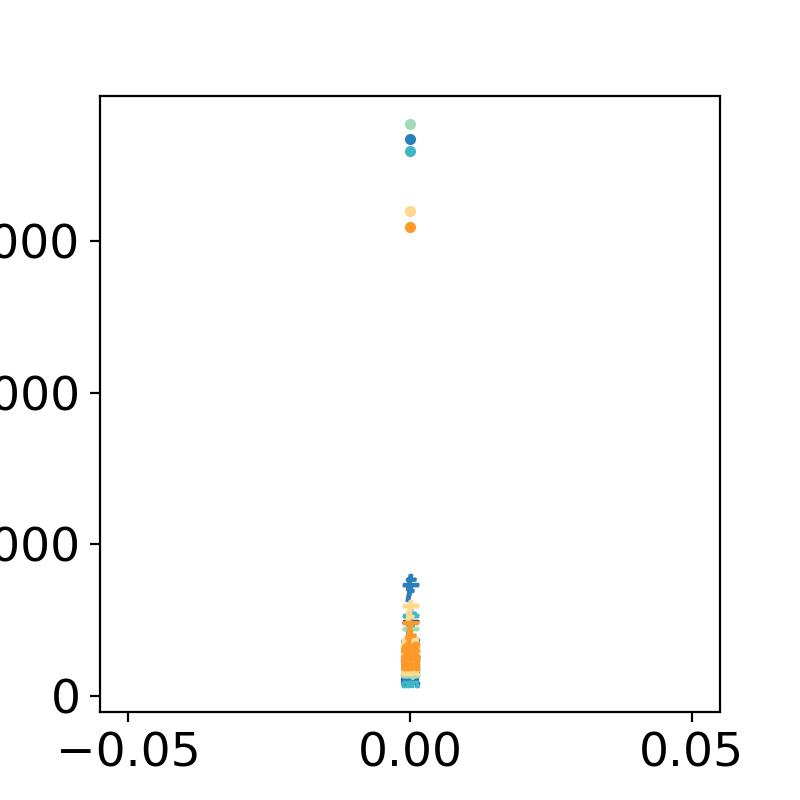

In [7]:
#mask_markers=['.','o','v','1','s','+','*','x']
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']
#help(mpl.markers)
subj_idx=1
for subj in dist_Ts_Tatlas:
  marker_idx=0
  plt.plot(dist_Ts_Tatlas[subj]['atlas'],ls='',marker=markers[marker_idx],color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  marker_idx+=1
  for rmask in region_masks:
    for hemi in ["hemi1", "hemi2"]:
      plt.plot(dist_Ts_Tatlas[subj][rmask+"_"+hemi],ls='',marker=markers[marker_idx],color=interp_colors[subj_idx],label=f'{subj}_{rmask}_{hemi}')
      marker_idx+=1
        
  for smask in single_masks:
    plt.plot(dist_Ts_Tatlas[subj][smask],ls='',marker=markers[marker_idx],color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    marker_idx+=1
    
  subj_idx+=1  

<IPython.core.display.Javascript object>


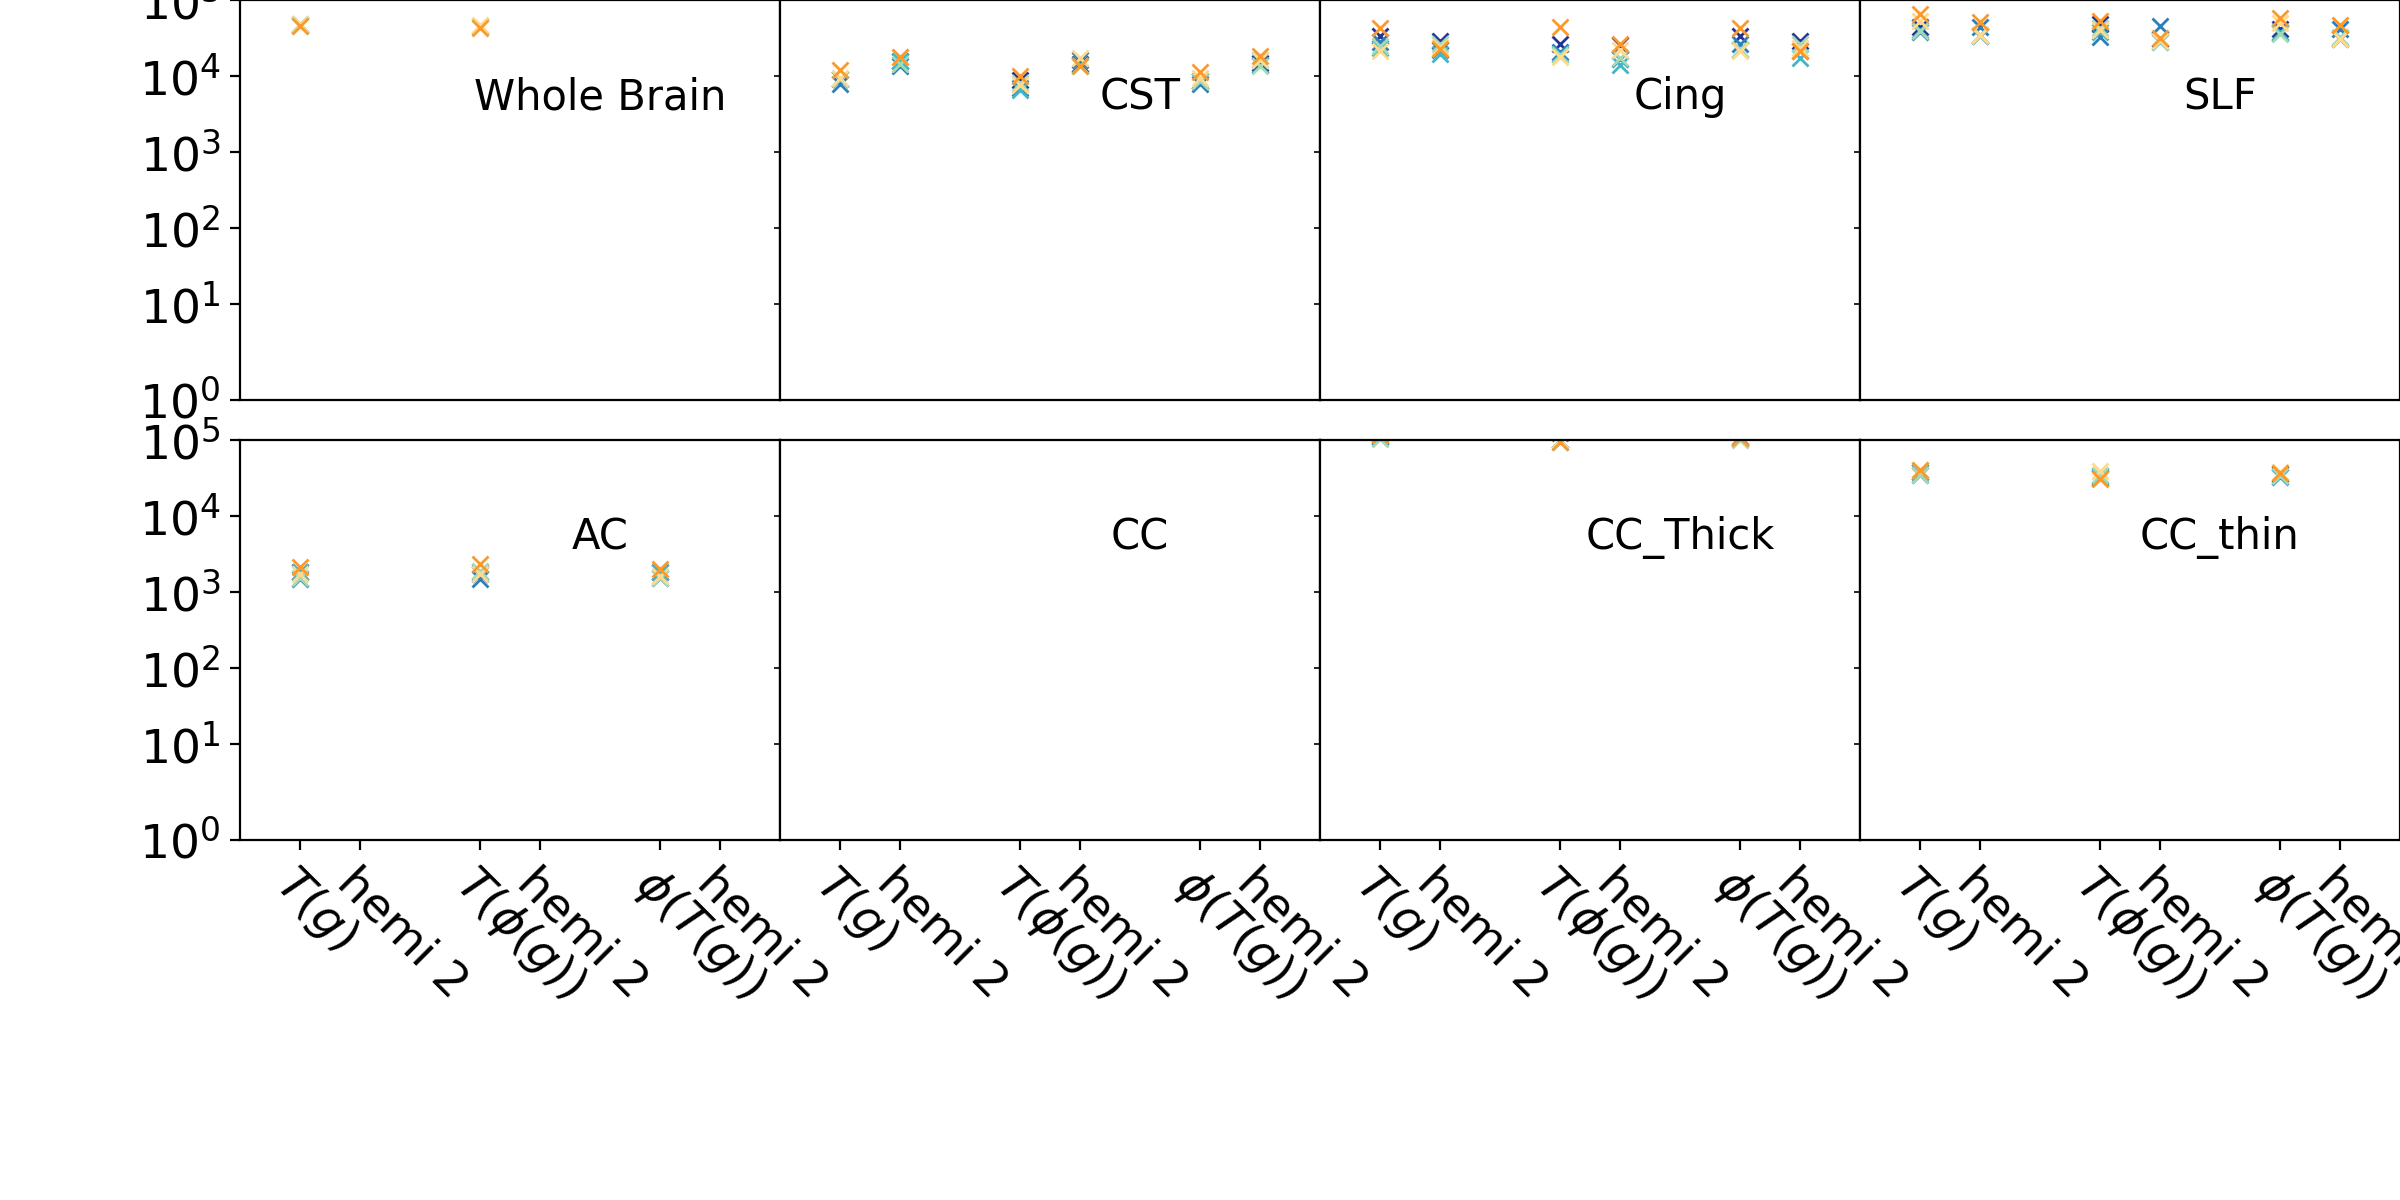

In [86]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,10**4] # right, bottom

dist_fig=plt.figure(figsize=(12,6))
rows = 2
cols = 4 

grid = plt.GridSpec(rows, cols, top=1, bottom=0.3, right=1, left=0.1, wspace=0, hspace=0.1)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
ax03 = plt.subplot(grid[0,3])
ax10 = plt.subplot(grid[1,0])
ax11 = plt.subplot(grid[1,1])
ax12 = plt.subplot(grid[1,2])
ax13 = plt.subplot(grid[1,3])
allax = [ax00,ax01,ax02,ax03,ax10,ax11,ax12,ax13]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

subj_idx=1
hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
for subj in dist_Ts_Tatlas:
  ax_idx=0
  plt.sca(allax[ax_idx])
  plt.plot(Ts_offs,dist_Ts_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(Tps_offs,dist_Tps_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_offs,dist_pTs_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  ax_idx+=1
  for rmask in region_masks:
    plt.sca(allax[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    ax_idx+=1
        
  for smask in single_masks:
    plt.sca(allax[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    ax_idx+=1
    
  subj_idx+=1 

axcnt = 0
for ax in allax:
  plt.sca(ax)
  plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  plt.ylim([1,10**5])
  plt.xlim([-0.5,4])
    
  t = ax.text(label_pt[0], label_pt[1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  if axcnt < 4:
    ax.set_xticks([])
  else:
    ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs])
    ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2'])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  if axcnt == 0 or axcnt == 4:
    pass
  else:
    ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
    
  axcnt += 1
    

<IPython.core.display.Javascript object>


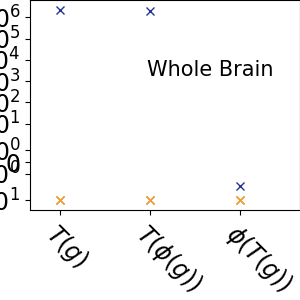

In [208]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,10**4] # right, bottom

dist_fig=plt.figure(figsize=(3,3))
rows = 1
cols = 1 

grid = plt.GridSpec(rows, cols, top=1, bottom=0.3, right=1, left=0.1, wspace=0, hspace=0.1)

ax00 = plt.subplot(grid[0,0])
allax = [ax00]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

subj_idx=1
hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
for subj in dist_Ts_Tatlas:
  ax_idx=0
  plt.sca(allax[ax_idx])
  plt.plot(Ts_offs,dist_Ts_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(Tps_offs,dist_Tps_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
  plt.plot(pTs_offs,dist_pTs_Tatlas[subj]['atlas'],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_whole_brain')
     
  subj_idx+=1 

axcnt = 0
for ax in allax:
  plt.sca(ax)
  plt.yscale('symlog')
  #plt.ylim([10**4,maxy*2])
  #plt.ylim([10**4.4,10**4.7])
  plt.xlim([-0.5,4])
    
  t = ax.text(label_pt[0], label_pt[1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs])
  ax.set_xticklabels(['$T(g)$','$T(\phi(g))$','$\phi(T(g))$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  ax.set_rasterization_zorder(-5)
    
  axcnt += 1
    

<IPython.core.display.Javascript object>


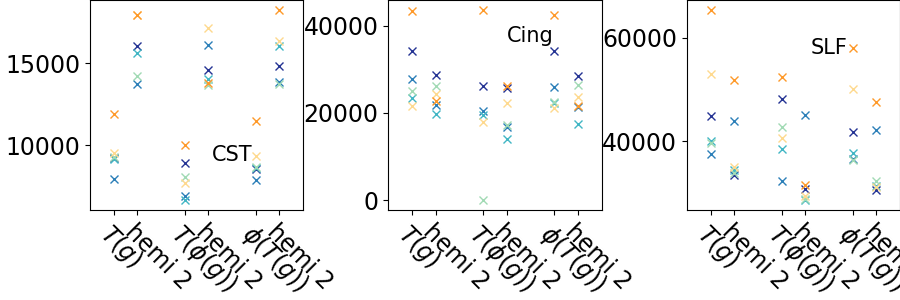

In [209]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,10**3] # right, bottom

dist_fig=plt.figure(figsize=(9,3))
rows = 1
cols = 3 

grid = plt.GridSpec(rows, cols, top=1, bottom=0.3, right=1, left=0.1, wspace=0.4, hspace=0.1)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
allax = [ax00,ax01,ax02]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

subj_idx=1
hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
for subj in dist_Ts_Tatlas:
  ax_idx=0
  for rmask in region_masks:
    plt.sca(allax[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Ts_offs+hemi2_offs,dist_Ts_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(Tps_offs+hemi2_offs,dist_Tps_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][rmask+"_hemi1"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi1')
    plt.plot(pTs_offs+hemi2_offs,dist_pTs_Tatlas[subj][rmask+"_hemi2"],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{rmask}_hemi2')
    ax_idx+=1
        
  subj_idx+=1 

label_pts = [[2.5,10000],[2.5,40000],[2.5,60000]] # right, bottom
lidx=0
axcnt = 1
for ax in allax:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([10**3,10**5])
  plt.xlim([-0.5,4])
    
  t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  ax.set_xticks([Ts_offs,Ts_offs+hemi2_offs,Tps_offs,Tps_offs+hemi2_offs,pTs_offs,pTs_offs+hemi2_offs])
  ax.set_xticklabels(['$T(g)$', 'hemi 2','$T(\phi(g))$','hemi 2','$\phi(T(g))$','hemi 2'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 1:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
    
  lidx += 1  
  axcnt += 1
    

<IPython.core.display.Javascript object>


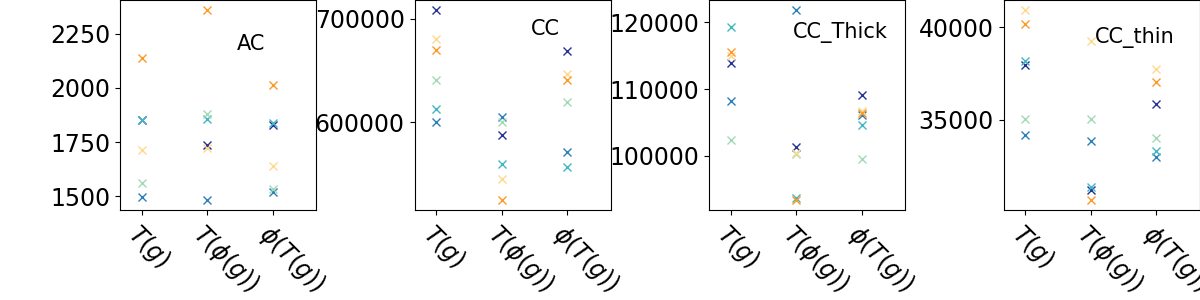

In [210]:
markers=['.','$CST1$','$CST2$','$Cing1$','$Cing2$','$SLF1$', '$SLF2$','$AC$','$CC$','$T$','$t$']

ax_labels = ['Whole Brain', 'CST', 'Cing', 'SLF', 'AC', 'CC', 'CC_Thick', 'CC_thin']
show_axis_labels = False

label_pt = [10,85] # left, top
label_pt = [50,85] # center, top
label_pt = [2.5,2250] # right, bottom

dist_fig=plt.figure(figsize=(12,3))
rows = 1
cols = 4 

grid = plt.GridSpec(rows, cols, top=1, bottom=0.3, right=1, left=0.1, wspace=0.5, hspace=0.1)

ax00 = plt.subplot(grid[0,0])
ax01 = plt.subplot(grid[0,1])
ax02 = plt.subplot(grid[0,2])
ax03 = plt.subplot(grid[0,3])
allax = [ax00,ax01,ax02,ax03]

#plt.plot(res['cubic2']['cubic_1246_subjspace_seed'][0],res['cubic2']['cubic_1246_subjspace_seed'][1],marker='x',color='black',markersize=10,linewidth=4)


maxy = max([distances[dist][dist_idx] for dist in distances])

subj_idx=1
hemi2_offs=0.5
Ts_offs=0
Tps_offs=1.5
pTs_offs=3
for subj in dist_Ts_Tatlas:
  ax_idx=0
        
  for smask in single_masks:
    plt.sca(allax[ax_idx])
    plt.plot(Ts_offs,dist_Ts_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(Tps_offs,dist_Tps_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    plt.plot(pTs_offs,dist_pTs_Tatlas[subj][smask],ls='',marker='x',color=interp_colors[subj_idx],label=f'{subj}_{smask}')
    ax_idx+=1
    
  subj_idx+=1 

axcnt = 4
label_pts = [[2.5,2250],[2.5,700000],[2.5,120000],[2.5,40000]] # right, bottom
lidx=0
for ax in allax:
  plt.sca(ax)
  #plt.yscale('symlog')
  #plt.ylim([1,maxy*2])
  #plt.ylim([1,10**5])
  plt.xlim([-0.5,4])
    
  t = ax.text(label_pts[lidx][0], label_pts[lidx][1], ax_labels[axcnt], ha="center", va="top", size=15, rasterized=False)
              #bbox=dict(fc="white", ec="none", lw=2, alpha=0))  
    
  #plt.grid(True,which="both")
  #if not show_axis_labels:
  ax.set_xticks([Ts_offs,Tps_offs,pTs_offs])
  ax.set_xticklabels(['$T(g)$', '$T(\phi(g))$','$\phi(T(g))$'])
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
  #if axcnt == 4:
  #  pass
  #else:
  #  ax.set_yticks([])
  ax.set_rasterization_zorder(-5)
  lidx += 1  
  axcnt += 1
    

In [24]:
print()

18850.741160591002


In [229]:
from util.diffeo import compose_function_3d
def apply_transform_to_img(in_img, diffeo):
  # use phi_inv and compose_function to take subj image into atlas space
  # use phi and compose_function to take atlas image into subj space
  try:
    torch.set_default_tensor_type('torch.DoubleTensor')
    print('Applying transform to image')

    with torch.no_grad():
      img_tfm_space = compose_function_3d(torch.from_numpy(in_img), torch.from_numpy(diffeo)).detach().numpy()

  except Exception as err:
    print('Caught', err, 'while applying transform to image')
  return(img_tfm_space)
  

In [230]:
atlasdir = f'/home/sci/hdai/Projects/Atlas3D/output/{hd_atlasname}/'
outsubjdir = f'/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/'
subj='100206'
atlas_mask = ReadScalars(atlasdir + f'atlas_mask_phi_inv_img_met_rreg_800.nhdr')
atlas_mask[atlas_mask < 0.3] = 0
atlas_mask[atlas_mask > 0] = 1
end_mask = atlas_mask
diffeo_img_to_subj_fname = atlasdir + f'{subj}_phi.mat'
img_diffeo = sio.loadmat(diffeo_img_to_subj_fname)['diffeo']
subj_tens = ReadTensors(f'{outsubjdir}/{subj}_scaled_orig_tensors_rreg.nhdr')
#end_mask = ReadScalars(f'{indir}/{subj}/dti_{bval}_FA_mask_0.20_rreg.nhdr')
end_mask_subj_space = apply_transform_to_img(end_mask, img_diffeo)
subj_tens_4_path = np.transpose(subj_tens,(3,0,1,2))
    

Applying transform to image


In [231]:
itkview(end_mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [235]:
mask=np.zeros_like(end_mask_subj_space)
mask[end_mask_subj_space>0] = 1
itkview(mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [236]:
mask=np.zeros_like(end_mask_subj_space)
mask[end_mask_subj_space>0.3] = 1
itkview(mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…